# **Performance Comparison of CNN, LSTM, and Hybrid CNN-LSTM for Cyber Attack Detection on CIC-IDS2017 Dataset**

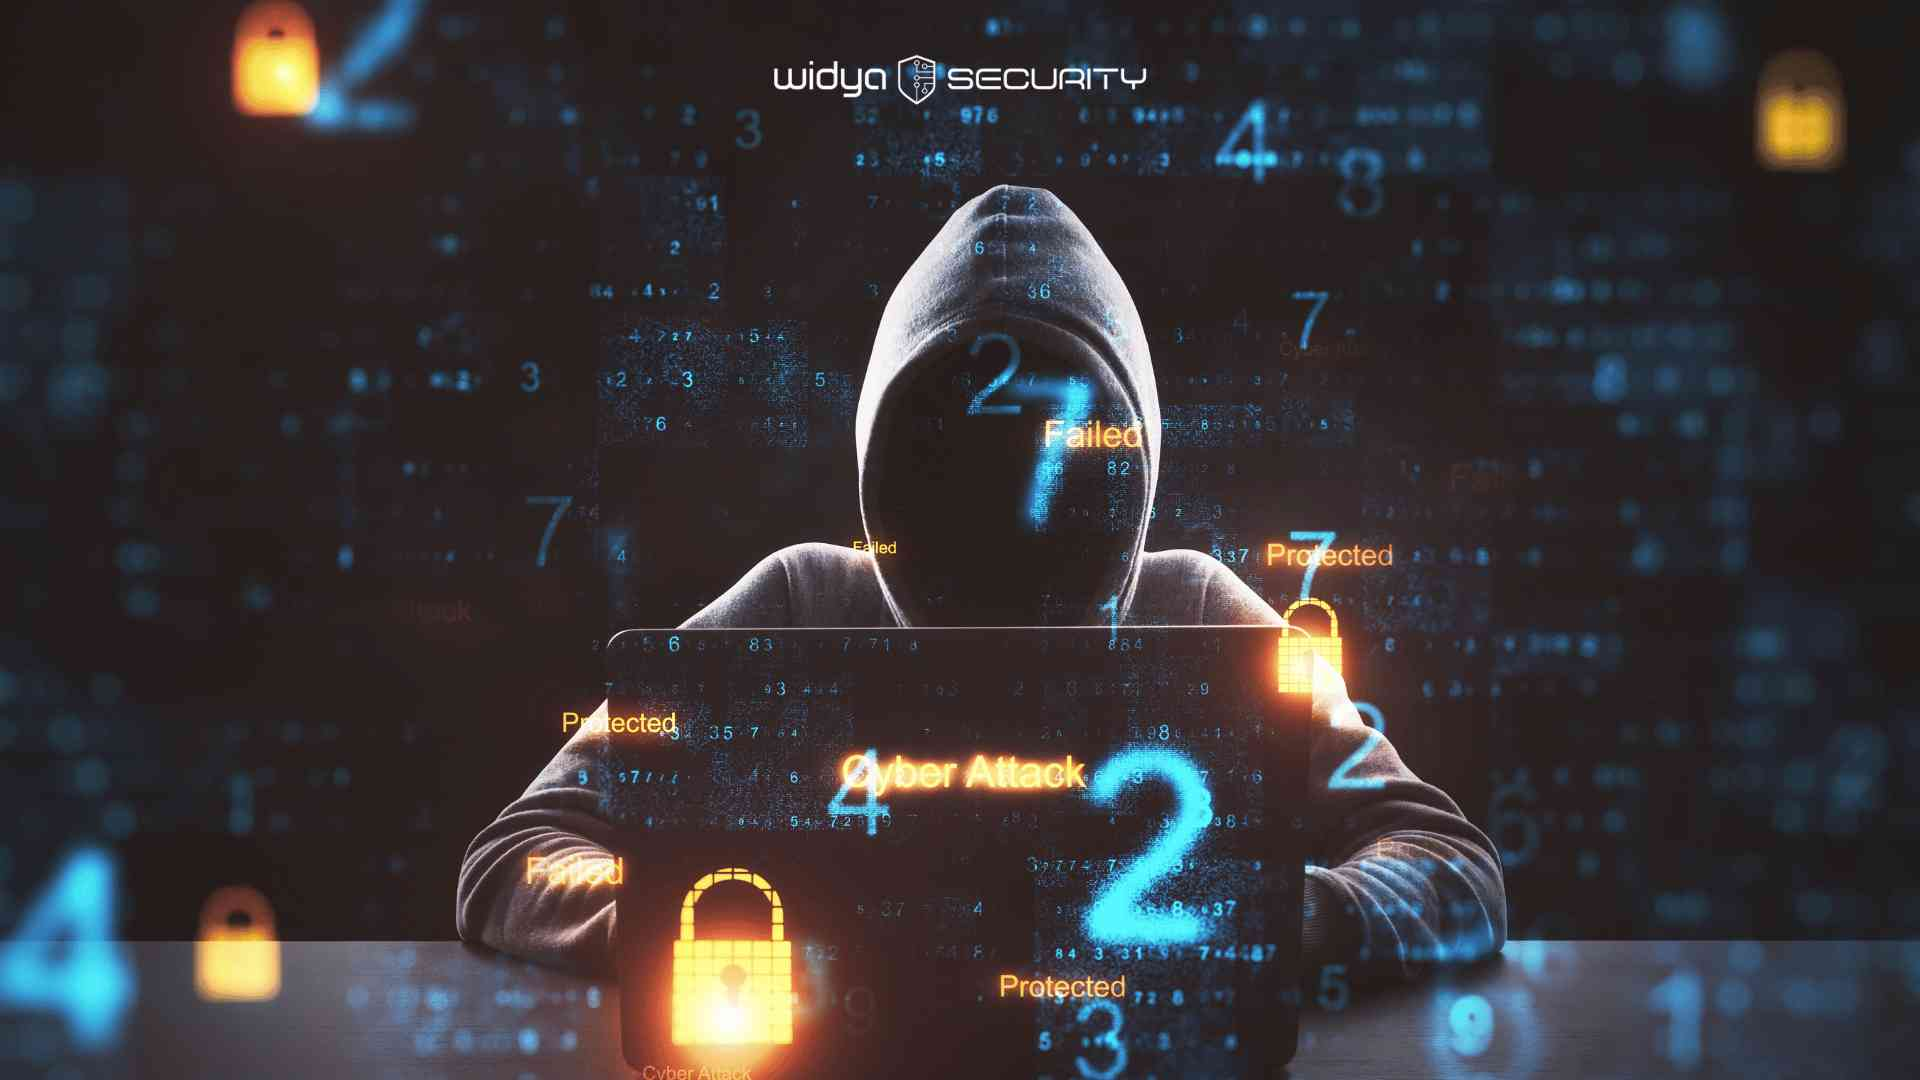

This notebook aims to analyze the performance of three deep learning models: CNN, LSTM, and a Hybrid CNN-LSTM. The dataset used is CIC-IDS2017, which includes cyber attack data for binary classification tasks. The notebook covers steps such as dataset downloading, data preprocessing, model building, and performance evaluation.

**Nawak Ngalam Team Members**

- Muhammad Hasan Fadhlillah - 225150207111026
- Muhammad Husain Fadhlillah - 225150207111027
- Abiyyu Kumara N - 225150201111004

## **1. Importing Required Libraries**

Libraries such as pandas, numpy, seaborn, and sklearn are used for data analysis and preprocessing. TensorFlow and Keras are utilized to build the deep learning models.

In [ ]:
import os
import kagglehub
import shutil
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

# Disabling warnings to keep the notebook clean
warnings.filterwarnings('ignore')

# Setting a random seed for reproducibility
np.random.seed(42)

## **2. Dataset Preparation**

### **2.1 Creating a Folder for the Dataset**

The CIC-IDS2017 dataset will be downloaded from Kaggle using kagglehub and moved to the "Dataset" folder.

In [ ]:
folderdataset = "/content/Dataset"

if not os.path.exists(folderdataset):
    os.makedirs(folderdataset)

# Downloading the dataset using KaggleHub
path = kagglehub.dataset_download("sweety18/cicids2017-full-dataset")

# Moving the dataset to the specified folder
for file in os.listdir(path):
    shutil.move(os.path.join(path, file), folderdataset)

print("Dataset telah diunduh dan dipindahkan ke:", folderdataset)

100%|██████████| 172M/172M [00:01<00:00, 93.2MB/s]

Extracting files...


Dataset telah diunduh dan dipindahkan ke: /content/Dataset


### **2.2 Loading the Dataset**

The main dataset file to be used is "combine.csv." This file combines data from all subsets of CIC-IDS2017.

In [ ]:
# Load dataset
file_path = "/content/Dataset/combine.csv"
data = pd.read_csv(file_path)

## **3. Exploratory Data Analysis (EDA)**

In this section, we perform an in-depth analysis of the dataset to understand its structure, characteristics, and any issues like missing values or outliers that need to be addressed.

### **3.1 Basic Information about the Dataset**
#### **Dataset Information**

Provides an overview of the dataset's structure, including data types and non-null counts.

In [ ]:
# Viewing Basic Information of the Dataset
print("=== Informasi Dataset ===")
print(data.info())

=== Informasi Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214469 entries, 0 to 2214468
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             object 
 1    Flow Duration                float64
 2    Total Fwd Packets            float64
 3    Total Backward Packets       float64
 4   Total Length of Fwd Packets   float64
 5    Total Length of Bwd Packets  float64
 6    Fwd Packet Length Max        float64
 7    Fwd Packet Length Min        float64
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         float64
 11   Bwd Packet Length Min        float64
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 

The dataset represents network traffic data with 2.2 million entries across 79 columns. It primarily consists of 77 floating-point columns and 2 categorical columns ('Destination Port' and 'Label'). The data captures comprehensive bidirectional network flow information, including packet counts, lengths, and timing metrics in both forward and backward directions.

The size of the dataset (1.3+ GB) and the presence of a 'Label' column suggests it's designed for network security analysis and traffic classification tasks. The features include essential network metrics like packet information, flow statistics, and various flag counts (FIN, SYN, RST), making it suitable for network traffic categorization and anomaly detection.

#### **Descriptive Statistics**

Summarizes numerical features in the dataset, including measures like mean, standard deviation, minimum, and maximum values.

In [ ]:
print("=== Statistik Deskriptif ===")
print(data.describe())

=== Statistik Deskriptif ===
        Flow Duration   Total Fwd Packets   Total Backward Packets  \
count    2.214468e+06        2.214468e+06             2.214468e+06   
mean     1.577101e+07        8.426575e+00             9.099413e+00   
std      3.447849e+07        6.855523e+02             9.072624e+02   
min     -1.300000e+01        1.000000e+00             0.000000e+00   
25%      1.360000e+02        2.000000e+00             1.000000e+00   
50%      3.131450e+04        2.000000e+00             2.000000e+00   
75%      4.336639e+06        5.000000e+00             5.000000e+00   
max      1.200000e+08        2.197590e+05             2.919220e+05   

       Total Length of Fwd Packets   Total Length of Bwd Packets  \
count                 2.214468e+06                  2.214468e+06   
mean                  5.525557e+02                  1.380931e+04   
std                   1.079827e+04                  2.058418e+06   
min                   0.000000e+00                  0.000000e+00   


The network traffic analysis reveals significant patterns in flow duration (mean: 15.77M units) and packet distribution (average: 8.43 forward, 9.10 backward packets). There's notable asymmetry in packet lengths, with backward packets (mean: 13,809 bytes) typically containing more data than forward packets (mean: 552.56 bytes).

The data shows mostly brief, bursty network flows rather than sustained connections, evidenced by many metrics having zero values at different percentiles. Active and Idle timing patterns suggest significant periods of inactivity between communications (mean idle time: 9.68M units). The presence of extreme maximum values and negative minimum segment sizes (-83.89M) indicates diverse network behaviors and possible anomalies in the traffic patterns.

### **3.2 Data Cleaning**
#### **Cleaning Column Names**

Removes unnecessary spaces from column names to ensure consistency and avoid potential errors during analysis.

In [ ]:
# Membersihkan nama kolom (spasi di awal dan akhir nama kolom)
data.columns = data.columns.str.strip()
print("=== 5 Data Pertama Setelah Pembersihan Kolom ===")
print(data.head())

=== 5 Data Pertama Setelah Pembersihan Kolom ===
  Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0            54865            3.0                2.0                     0.0   
1            55054          109.0                1.0                     1.0   
2            55055           52.0                1.0                     1.0   
3            46236           34.0                1.0                     1.0   
4            54863            3.0                2.0                     0.0   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                         12.0                          0.0   
1                          6.0                          6.0   
2                          6.0                          6.0   
3                          6.0                          6.0   
4                         12.0                          0.0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0               

The data shows different network connections using various destination ports (54865, 55054, 55055, 46236, and 54863) with varying flow durations ranging from 3 to 109 units. The packet metrics reveal minimal traffic patterns, with most connections showing either 1 or 2 forward packets and 0 or 1 backward packets. The packet lengths are consistent at 6 bytes for most cases, with some flows showing 12 bytes for forward packets.

All timing-related metrics (Active and Idle measurements) show zero values, indicating very brief connections. Each flow is labeled as "BENIGN," suggesting normal network behavior. The minimum segment size is consistent at 20.0 across all entries. Overall, these five entries appear to represent standard, short-lived network connections with minimal data exchange.

#### **Dropping Unnecessary Columns**

Removes columns that are not useful for the analysis, such as "Destination Port."

In [ ]:
# Menghapus kolom yang tidak diperlukan
data.drop(columns=['Destination Port'], inplace=True)
print("=== 5 Data Pertama Setelah Penghapusan Kolom ===")
print(data.head())

=== 5 Data Pertama Setelah Penghapusan Kolom ===
   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0            3.0                2.0                     0.0   
1          109.0                1.0                     1.0   
2           52.0                1.0                     1.0   
3           34.0                1.0                     1.0   
4            3.0                2.0                     0.0   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                         12.0                          0.0   
1                          6.0                          6.0   
2                          6.0                          6.0   
3                          6.0                          6.0   
4                         12.0                          0.0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                    6.0                    6.0                     6.0   
1                    6.0                   

The dataset preprocessing involved removing the 'Destination Port' column, resulting in a dataset with 78 remaining columns. The first 5 rows of data reveal important network traffic characteristics such as Flow Duration (ranging from 3.0 to 109.0 seconds), Total Forward and Backward Packets (mostly 1-2 packets), and various packet length measurements. All five samples are labeled as "BENIGN" traffic, indicating they represent normal network behavior. Most of the Active and Idle time metrics show zero values, suggesting these are short-duration network connections.

### **3.3 Dataset Size**

Displays the dimensions of the dataset (number of rows and columns).

In [ ]:
# Melihat ukuran dataset
print("=== Ukuran Dataset ===")
print(f"Jumlah baris dan kolom: {data.shape}")

=== Ukuran Dataset ===
Jumlah baris dan kolom: (2214469, 78)


The dataset analysis reveals substantial dimensions, containing 2,214,469 rows (instances) and 78 columns (features). This indicates a large-scale network traffic dataset with extensive sample records. The high number of rows suggests comprehensive network traffic monitoring, capturing over 2 million network flow instances. The 78 columns represent various network traffic characteristics and metrics used to describe each flow. The size of this dataset is significant enough to perform meaningful machine learning analysis, particularly for network traffic classification or anomaly detection tasks.

### **3.4 Label Analysis**
#### **Label Distribution**

Analyzes the distribution of labels to check for class imbalance and visualizes the results using bar plots and pie charts.

=== Distribusi Label ===
Label
BENIGN              1672837
DoS Hulk             231073
PortScan             158930
DDoS                 128027
DoS GoldenEye         10293
DoS slowloris          5796
DoS Slowhttptest       5499
Bot                    1966
Infiltration             36
Heartbleed               11
Name: count, dtype: int64


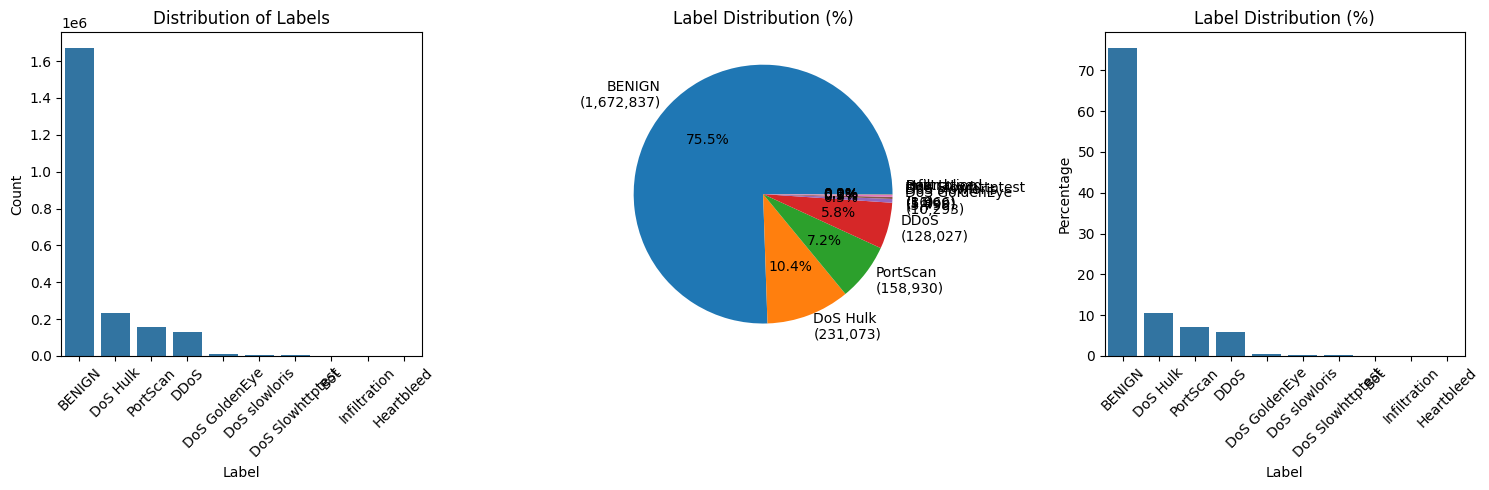

In [ ]:
# Analisis Label
print("=== Distribusi Label ===")
label_counts = data['Label'].value_counts()
print(label_counts)

# Visualisasi Distribusi Label
plt.figure(figsize=(15, 5))

# Bar plot distribusi label
plt.subplot(131)
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Pie chart distribusi label
plt.subplot(132)
plt.pie(label_counts.values,
        labels=[f'{label}\n({count:,})' for label, count in zip(label_counts.index, label_counts.values)],
        autopct='%1.1f%%')
plt.title('Label Distribution (%)')

# Bar plot persentase
plt.subplot(133)
label_percentages = (label_counts / len(data) * 100).round(2)
sns.barplot(x=label_percentages.index, y=label_percentages.values)
plt.title('Label Distribution (%)')
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

The analysis of the network traffic dataset reveals a significant imbalance in the distribution of labels across different types of network activities. The data shows that normal "BENIGN" traffic dominates the dataset with 1,672,837 instances, representing approximately 75.5% of all traffic. This is followed by various types of attack traffic, with "DoS Hulk" being the most common attack type (231,073 instances, 10.4%), "PortScan" (158,930 instances, 7.2%), and "DDoS" (128,027 instances, 5.8%) forming the next major categories.

The less frequent attack types include "DoS GoldenEye" (10,293 instances), "DoS slowloris" (5,796 instances), and "DoS Slowhttptest" (5,499 instances). The dataset also contains a very small number of instances for "Bot" (1,966), "Infiltration" (36), and "Heartbleed" (11) attacks, making these categories particularly underrepresented. This imbalanced distribution is clearly visualized through three different plots - a bar chart showing absolute counts, a pie chart displaying percentage distributions, and a bar chart showing percentage values, all of which highlight the significant predominance of benign traffic over various attack types.

### **3.5 Correlation Analysis**
#### **Correlation Matrix**

Computes and visualizes correlations between numerical features to identify potential relationships or redundancies.

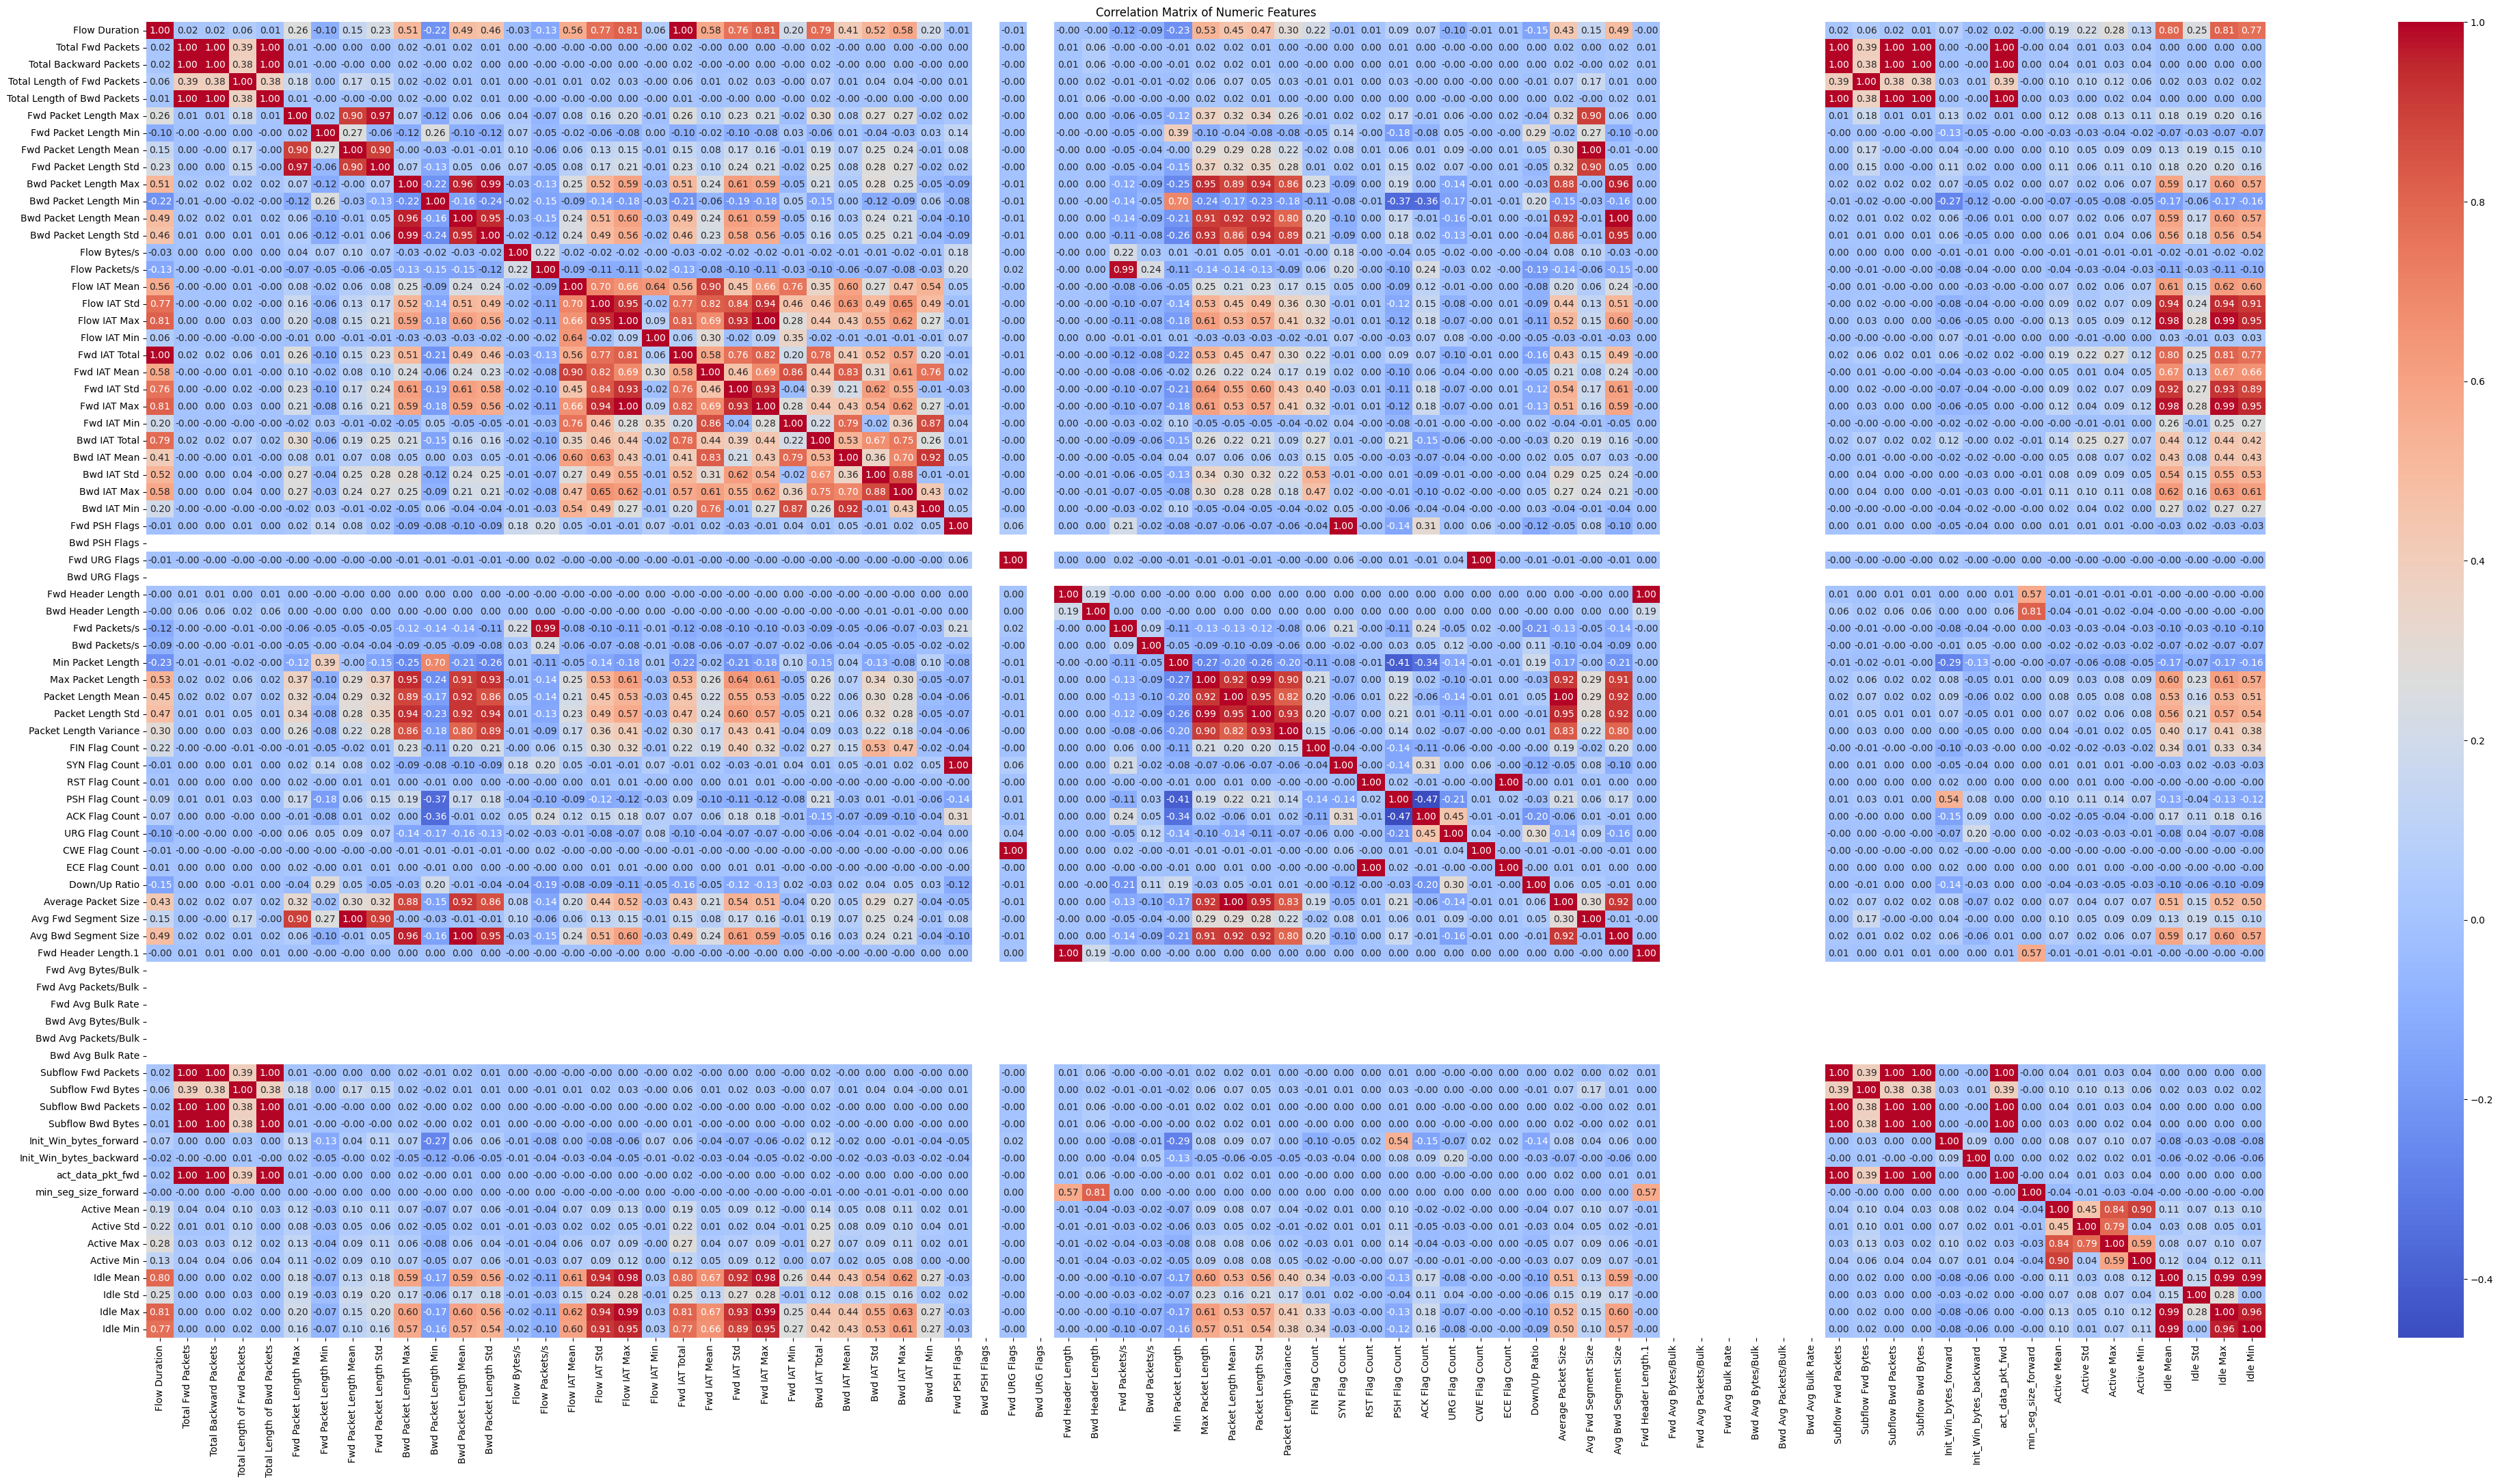

In [ ]:
# Pilih hanya kolom numerik
numeric_data = data.select_dtypes(include=['number'])

# Hitung korelasi
correlation_matrix = numeric_data.corr()

# Visualisasi korelasi
plt.figure(figsize=(50, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

The correlation matrix heatmap visualization reveals complex relationships between the numeric features in the network traffic dataset. The matrix uses a color scheme ranging from dark blue (strong negative correlation) to dark red (strong positive correlation), with values ranging from -1 to 1.

Several notable patterns emerge from the visualization. There are distinct clusters of highly correlated features, particularly among related packet characteristics. For example, various packet length measurements show strong positive correlations with each other, as indicated by the red squares in their intersections. Flow-related metrics also demonstrate significant correlations among themselves. Some features exhibit strong negative correlations, shown in dark blue, suggesting inverse relationships between certain network traffic characteristics.

The matrix also reveals many features with weak or negligible correlations, displayed in lighter shades, indicating that these features might provide independent information useful for traffic classification. This pattern of correlations suggests that while some features might be redundant due to high correlation, others provide unique information that could be valuable for detecting different types of network activities and attacks.

This correlation analysis could be particularly useful for feature selection in subsequent machine learning models, potentially helping to identify which features are most informative and which might be redundant for network traffic classification tasks.

#### **Missing Values in Correlation**

Checks for missing values in the correlation matrix to ensure data completeness.

In [ ]:
# Analisis Missing Values dalam Korelasi
print("=== Missing Values dalam Matriks Korelasi ===")
print(correlation_matrix.isnull().sum())

=== Missing Values dalam Matriks Korelasi ===
Flow Duration                  8
Total Fwd Packets              8
Total Backward Packets         8
Total Length of Fwd Packets    8
Total Length of Bwd Packets    8
                              ..
Active Min                     8
Idle Mean                      8
Idle Std                       8
Idle Max                       8
Idle Min                       8
Length: 77, dtype: int64


The analysis of missing values in the correlation matrix reveals a consistent pattern across all 77 numeric features in the dataset. Each feature shows exactly 8 missing values, indicating a uniform distribution of missing data. This consistency is noteworthy as it spans across various types of network traffic measurements, from basic flow duration and packet counts to more specific metrics like active and idle times.

The presence of missing values is systematic across all features, suggesting these gaps might have occurred during the data collection process or due to specific network conditions that affected all measurements simultaneously. This pattern of missing values is particularly important to consider for any subsequent analysis or modeling tasks, as it may impact the reliability of the correlation calculations and might need to be addressed through appropriate data preprocessing techniques before further analysis.

### **3.6 Outlier Detection**
#### **Box Plot Analysis**

Uses box plots to identify potential outliers in the dataset for the first five numerical features.

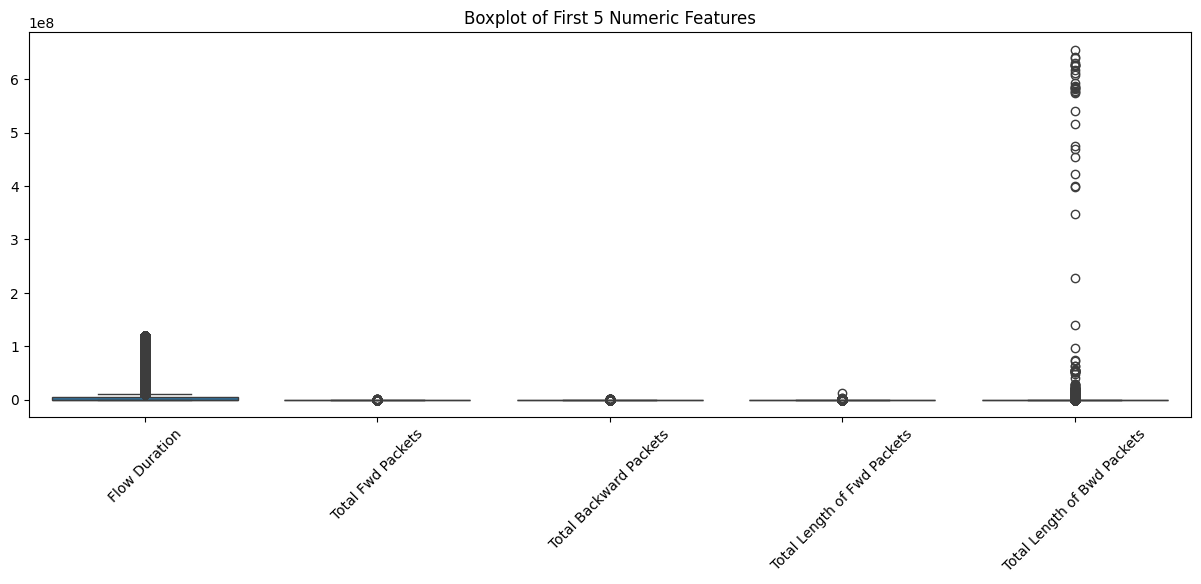

In [ ]:
# Box Plot untuk Outlier Detection
plt.figure(figsize=(15, 5))
sns.boxplot(data=numeric_data.iloc[:, :5])  # Mengambil 5 fitur pertama
plt.title('Boxplot of First 5 Numeric Features')
plt.xticks(rotation=45)
plt.show()

The boxplot visualization of the first five numeric features in the network traffic dataset reveals significant outliers and varying distributions across the features. Flow Duration shows a concentrated distribution with numerous outliers extending up to 1x10^8, indicating some network connections last significantly longer than typical ones. Total Forward Packets and Total Backward Packets display similar patterns with most values clustered near the bottom of the scale, but with outliers reaching higher values, suggesting occasional bursts of heavy packet traffic.

The Total Length of Forward Packets and Total Length of Backward Packets exhibit particularly extreme outliers, with some values reaching up to 6x10^8, far above the median values. These outliers could represent unusual network events or potential attack patterns. All five features show a strong positive skew, with the majority of values concentrated near the lower end of their ranges, which is typical for network traffic data where most connections are relatively small and brief, but occasional large transfers or anomalous activities create extreme values.

### **3.7 Missing Values Analysis**
#### **Dataset Missing Values**

Analyzes missing values in the dataset to determine if imputation or removal is required.

In [ ]:
# Analisis Missing Values Dataset
missing_values = data.isnull().sum()
print("=== Missing Values per Kolom ===")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "Tidak ada missing values")

=== Missing Values per Kolom ===
Flow Duration                  1
Total Fwd Packets              1
Total Backward Packets         1
Total Length of Fwd Packets    1
Total Length of Bwd Packets    1
                              ..
Idle Mean                      1
Idle Std                       1
Idle Max                       1
Idle Min                       1
Label                          1
Length: 78, dtype: int64


The analysis of missing values in the dataset reveals a uniform pattern of missing data across all 78 columns, including both numeric features and the Label column. Each feature has exactly one missing value, indicating a very small and consistent presence of missing data. This pattern suggests that these missing values might be related to a single incomplete record in the dataset rather than random data gaps across different records.

Given that each column has just one missing value out of over 2 million records (as previously noted in the dataset size), the impact of these missing values on the overall analysis is minimal. The uniform distribution of missing values across all features suggests that this might be due to a single failed data collection instance or a systematic error that affected one particular network traffic record. This level of missing data is unlikely to significantly impact the analysis or model performance if properly handled during the preprocessing stage.

### **3.8 Dataset Summary**

Summarizes the dataset's key characteristics, such as total rows, features, numeric and categorical columns, and missing values.

In [ ]:
# Summary Dataset
print("=== Summary Dataset ===")
print(f"Total Rows: {len(data):,}")
print(f"Total Features: {len(data.columns):,}")
print(f"Numeric Features: {len(numeric_data.columns):,}")
print(f"Categorical Features: {len(data.select_dtypes(include=['object']).columns):,}")
print(f"Missing Values: {data.isnull().sum().sum():,}")

=== Summary Dataset ===
Total Rows: 2,214,469
Total Features: 78
Numeric Features: 77
Categorical Features: 1
Missing Values: 1,215


The dataset analyzed comprises **2,214,469 rows** and **78 features**, of which **77 are numeric** and **1 is categorical**. A total of **1,215 missing values** were identified across the dataset. Given the size of the dataset, the proportion of missing values is extremely small, representing approximately **0.05%** of the total data points. This minimal level of missing data suggests that it is unlikely to introduce significant bias or affect the overall quality of the dataset.  

The overwhelming majority of features are numeric, indicating that the dataset is likely structured for analytical tasks involving quantitative modeling, such as regression or classification. The presence of only one categorical feature implies a limited need for encoding categorical data, streamlining preprocessing efforts.  

The low count of missing values may be attributed to isolated cases of incomplete records rather than widespread data quality issues. These gaps can be efficiently addressed through imputation techniques or removal without risking data loss or compromising statistical integrity. Given the dataset's size and structure, it is well-suited for machine learning tasks following minor preprocessing adjustments.

## **4. Preprocessing**

### **4.1 Initial Data Cleaning**

The first step in preprocessing is cleaning the dataset by selecting only numeric columns and removing features with zero variance. This ensures that the dataset is free of constant columns that do not contribute to model training.

In [ ]:
# Preprocessing - Pembersihan Data Awal

print("=== TAHAP 1: PEMBERSIHAN DATA AWAL ===")
# Mengambil kolom numerik
numeric_data = data.select_dtypes(include=['number'])
print("Jumlah kolom numerik:", len(numeric_data.columns))

# Menghitung varians untuk menghapus kolom konstan
variances = numeric_data.var()
columns_to_keep = variances[variances != 0].index
data_cleaned = data[columns_to_keep]
print("\nJumlah kolom setelah menghapus kolom konstan:", len(data_cleaned.columns))

=== TAHAP 1: PEMBERSIHAN DATA AWAL ===
Jumlah kolom numerik: 77

Jumlah kolom setelah menghapus kolom konstan: 69


The initial data preprocessing phase focused on cleaning and refining the dataset by addressing constant features. Out of **77 numeric columns** identified in the dataset, a variance analysis was performed to detect and remove constant columns—features with zero variance—since they do not provide any meaningful information for analysis or modeling.  

Following this step, the number of numeric features was reduced from **77 to 69**, indicating that **8 columns** were identified as constant and subsequently excluded. This reduction improves dataset quality by eliminating redundant features, thereby enhancing computational efficiency and reducing the risk of overfitting during model training.  

The resulting dataset retains only features with variability, ensuring that subsequent analytical or machine-learning processes focus on attributes that can meaningfully contribute to patterns or predictions. This streamlined dataset is now better prepared for further preprocessing, feature engineering, or modeling.

### **4.2 Handling Outliers**

Outliers are addressed using the IQR method. This reduces the impact of extreme values on the model.

=== TAHAP 2: HANDLING OUTLIERS ===


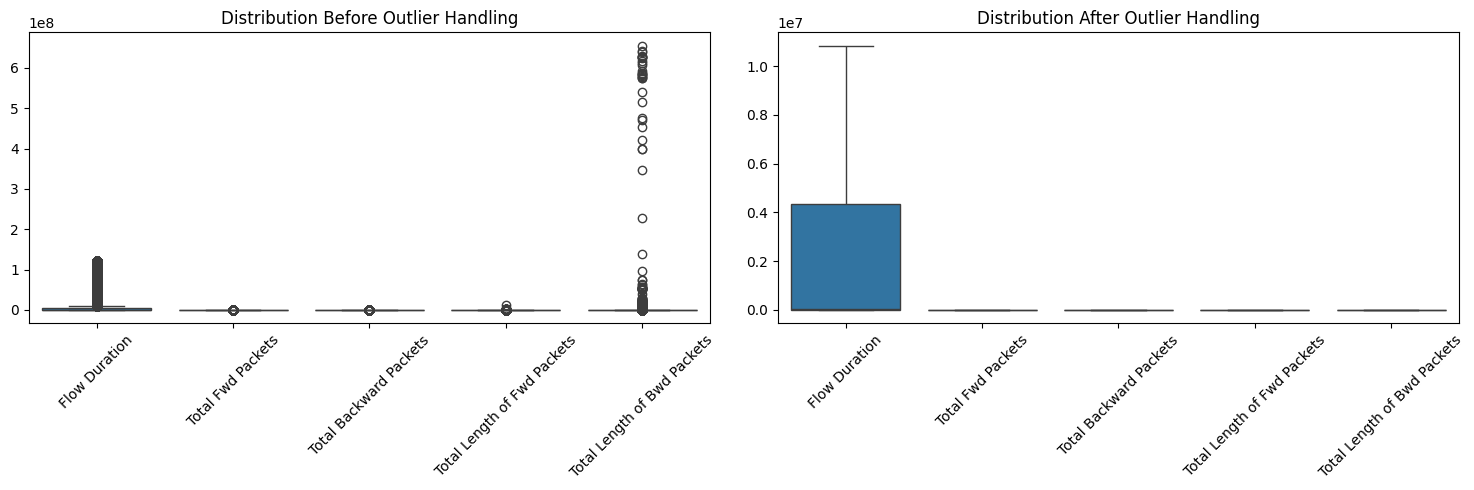

In [ ]:
# Handling Outliers dengan IQR Method
print("=== TAHAP 2: HANDLING OUTLIERS ===")
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean[column] = df_clean[column].clip(lower=lower_bound, upper=upper_bound)
    return df_clean

# Visualisasi sebelum handling outliers (5 kolom pertama)
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.boxplot(data=data_cleaned[data_cleaned.select_dtypes(include=['number']).columns[:5]])
plt.title('Distribution Before Outlier Handling')
plt.xticks(rotation=45)

# Handling outliers
numeric_columns = data_cleaned.select_dtypes(include=['number']).columns
data_cleaned = remove_outliers_iqr(data_cleaned, numeric_columns)

# Visualisasi setelah handling outliers
plt.subplot(122)
sns.boxplot(data=data_cleaned[data_cleaned.select_dtypes(include=['number']).columns[:5]])
plt.title('Distribution After Outlier Handling')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The visual analysis presented compares the distribution of several numeric features before and after outlier handling using the **Interquartile Range (IQR) method**.  

In the **"Before Outlier Handling"** plot, the boxplots reveal the presence of significant outliers across all five selected features, particularly in "Flow Duration" and "Total Length of Bwd Packets," where extreme values are highly dispersed. These outliers can skew statistical measures, such as the mean, and negatively affect model performance by introducing noise.  

In contrast, the **"After Outlier Handling"** plot demonstrates a more compact and symmetric distribution for each feature. The IQR method effectively clipped extreme values outside the 1.5 times IQR range, replacing them with the calculated upper and lower bounds. As a result, the cleaned data now exhibits fewer extreme values, leading to improved consistency and stability in the dataset.  

This preprocessing step ensures that the dataset is better suited for machine learning models by reducing the impact of outliers and enhancing the reliability of statistical patterns. Further analysis can now proceed with minimized risk of distortions caused by extreme values.

### **4.3 Removing Highly Correlated Features**

Features with a correlation above 0.9 are removed to prevent multicollinearity, which can adversely affect model performance.

In [ ]:
# Menghapus Fitur dengan Korelasi Tinggi
print("=== TAHAP 3: MENGHAPUS FITUR BERKORELASI TINGGI ===")

# Exclude 'Label' from correlation calculation
correlation_data = data_cleaned.drop(columns=['Label'], errors='ignore') # Exclude 'Label' if present
correlation_matrix = correlation_data.corr()

upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
to_drop = [column for column in upper_triangle.columns if any(abs(upper_triangle[column]) > 0.9)]

print("Kolom yang akan dihapus karena korelasi tinggi:", to_drop)
data_cleaned.drop(columns=to_drop, inplace=True, errors='ignore') # Handle potential KeyError if columns are already removed

=== TAHAP 3: MENGHAPUS FITUR BERKORELASI TINGGI ===
Kolom yang akan dihapus karena korelasi tinggi: ['Fwd Packet Length Max', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes']


In this phase, features with **high correlation (above 0.9)** were identified and removed to address multicollinearity issues in the dataset. High correlation among features can lead to redundancy, reduced model interpretability, and overfitting during machine learning model training.  

The analysis detected **30 highly correlated features**, including metrics related to packet lengths, flow inter-arrival times (IAT), and header lengths. These features were excluded to simplify the dataset while retaining meaningful, non-redundant attributes. Key features such as **"Fwd Packet Length Max"**, **"Flow IAT Mean"**, and **"Packet Length Variance"** were among those removed due to their strong correlation with other features.

In [ ]:
# Menambahkan kembali kolom 'Label' ke dalam data_cleaned
data_cleaned['Label'] = data['Label']

# Memeriksa kolom yang tersisa setelah penghapusan
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214469 entries, 0 to 2214468
Data columns (total 39 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Flow Duration                float64
 1   Total Fwd Packets            float64
 2   Total Backward Packets       float64
 3   Total Length of Fwd Packets  float64
 4   Total Length of Bwd Packets  float64
 5   Fwd Packet Length Min        float64
 6   Fwd Packet Length Mean       float64
 7   Bwd Packet Length Min        float64
 8   Flow Bytes/s                 float64
 9   Flow Packets/s               float64
 10  Flow IAT Min                 float64
 11  Fwd IAT Min                  float64
 12  Bwd IAT Total                float64
 13  Bwd IAT Min                  float64
 14  Fwd PSH Flags                float64
 15  Fwd URG Flags                float64
 16  Bwd Packets/s                float64
 17  FIN Flag Count               float64
 18  SYN Flag Count               float64
 19  

Following this refinement, the dataset now contains **39 features** (including the **"Label"** column), reduced from the initial set of **69 features** after outlier handling. This significant reduction in dimensionality improves computational efficiency and reduces the risk of overfitting while preserving essential patterns for predictive modeling.  

The final dataset structure consists of **38 numeric features** and **1 categorical feature (Label)**, making it well-prepared for subsequent analysis or machine-learning tasks. With its optimized size and reduced redundancy, the dataset is now better equipped for training robust and interpretable models.

### **4.4 Handling Missing and Infinite Values**

Infinite values are replaced with NaN, and missing values are filled with the median of each column.

In [ ]:
# Handling Missing Values dan Infinite Values
print("=== TAHAP 4: HANDLING MISSING DAN INFINITE VALUES ===")
# Replace infinite values dengan NaN
data_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN dengan median
numeric_data = data_cleaned.select_dtypes(include=[np.number])
data_cleaned[numeric_data.columns] = numeric_data.fillna(numeric_data.median())

=== TAHAP 4: HANDLING MISSING DAN INFINITE VALUES ===


### **4.5 Label Encoding**

The target variable 'Label' is encoded into binary values: 0 for 'BENIGN' and 1 for attacks.

In [ ]:
# Label Encoding
print("=== TAHAP 5: LABEL ENCODING ===")
data_cleaned['Label'] = data_cleaned['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
print("\nDistribusi Label setelah encoding:")
print(data_cleaned['Label'].value_counts())

=== TAHAP 5: LABEL ENCODING ===

Distribusi Label setelah encoding:
Label
0    1672837
1     541632
Name: count, dtype: int64


In this step, the **'Label'** column, which represents the target variable, was encoded into binary values to facilitate machine learning model training. The encoding assigns **0** to the **'BENIGN'** class, indicating normal traffic, and **1** to the attack-related instances, representing anomalies or malicious activities.  

The distribution of the encoded labels reveals that **1,672,837 instances (approximately 75.5%)** belong to the **BENIGN** class, while **541,632 instances (approximately 24.5%)** are classified as attacks. This distribution highlights a **class imbalance**, where benign traffic significantly outnumbers attack instances.  

Such an imbalance can impact model performance, particularly for classifiers, as models may become biased toward the majority class. To address this, techniques such as **oversampling, undersampling**, or **cost-sensitive learning** might be required to ensure balanced model training and improve detection of minority class instances.  

With the target variable now encoded, the dataset is ready for further preprocessing steps, such as scaling and splitting into training and testing sets, in preparation for machine-learning modeling.

In [ ]:
# Split Features dan Target
X = data_cleaned.drop(columns=['Label'])
y = data_cleaned['Label']

### **4.6 Standardization**

Features are standardized to ensure all have a mean of 0 and a standard deviation of 1, which is essential for most machine learning algorithms.

In [ ]:
# Standardization
print("=== TAHAP 6: STANDARDIZATION ===")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

=== TAHAP 6: STANDARDIZATION ===


### **4.7 Balancing the Dataset**

The dataset is balanced using Random Undersampling to address class imbalance.

=== TAHAP 7: BALANCING DATASET ===
Distribusi label sebelum balancing:
Counter({0: 1672837, 1: 541632})

Distribusi label setelah balancing:
Counter({0: 541632, 1: 541632})


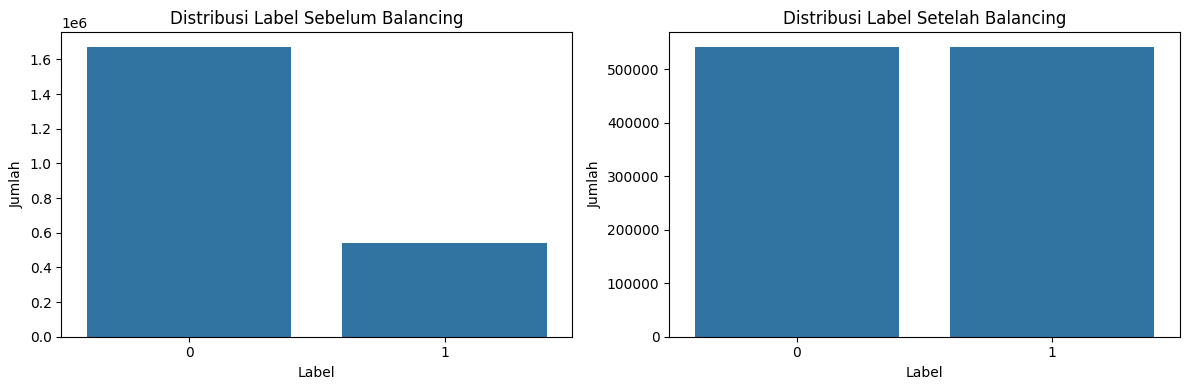

In [ ]:
# Balancing Dataset dengan Random Undersampling
print("=== TAHAP 7: BALANCING DATASET ===")
print("Distribusi label sebelum balancing:")
print(Counter(y))

# Menggunakan Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X_scaled, y)

print("\nDistribusi label setelah balancing:")
print(Counter(y_balanced))

# Visualisasi distribusi label sebelum dan sesudah balancing
plt.figure(figsize=(12, 4))

plt.subplot(121)
sns.countplot(x=y)
plt.title('Distribusi Label Sebelum Balancing')
plt.xlabel('Label')
plt.ylabel('Jumlah')

plt.subplot(122)
sns.countplot(x=y_balanced)
plt.title('Distribusi Label Setelah Balancing')
plt.xlabel('Label')
plt.ylabel('Jumlah')

plt.tight_layout()
plt.show()

The dataset underwent **random undersampling** to address the class imbalance observed in the target variable. Initially, the dataset exhibited a significant imbalance, with **1,672,837 instances (approximately 75.5%)** classified as **benign (Label 0)** and **541,632 instances (approximately 24.5%)** labeled as **attacks (Label 1)**.  

Random undersampling reduced the number of majority class samples (Label 0) to match the minority class (Label 1), resulting in a **balanced distribution** of **541,632 instances per class**. This balancing process prevents bias in machine learning models, ensuring equal weight is given to both classes and improving performance in detecting attacks.  

The bar charts visually confirm the shift from an **imbalanced dataset** before sampling to a **balanced dataset** after undersampling. While this method effectively balances the labels, it also reduces the total dataset size, potentially discarding useful information. Careful evaluation of model performance will be necessary to determine if undersampling impacts predictive accuracy.  

The balanced dataset is now more suitable for training classification models, particularly for addressing scenarios where minority class detection is critical, such as anomaly or intrusion detection.

### **4.8 Post-Preprocessing Analysis**

This stage ensures the dataset is clean, balanced, and ready for modeling.

=== EDA SETELAH PREPROCESSING DAN BALANCING ===

=== ANALISIS MISSING VALUES ===
Missing Values di Feature Matrix (X):
Tidak ada missing values di feature matrix

Missing Values di Target Variable (y):
Tidak ada missing values di target variable

Statistik Missing Values:
Total sel data: 41164032
Total missing values: 0
Persentase missing values: 0.00%


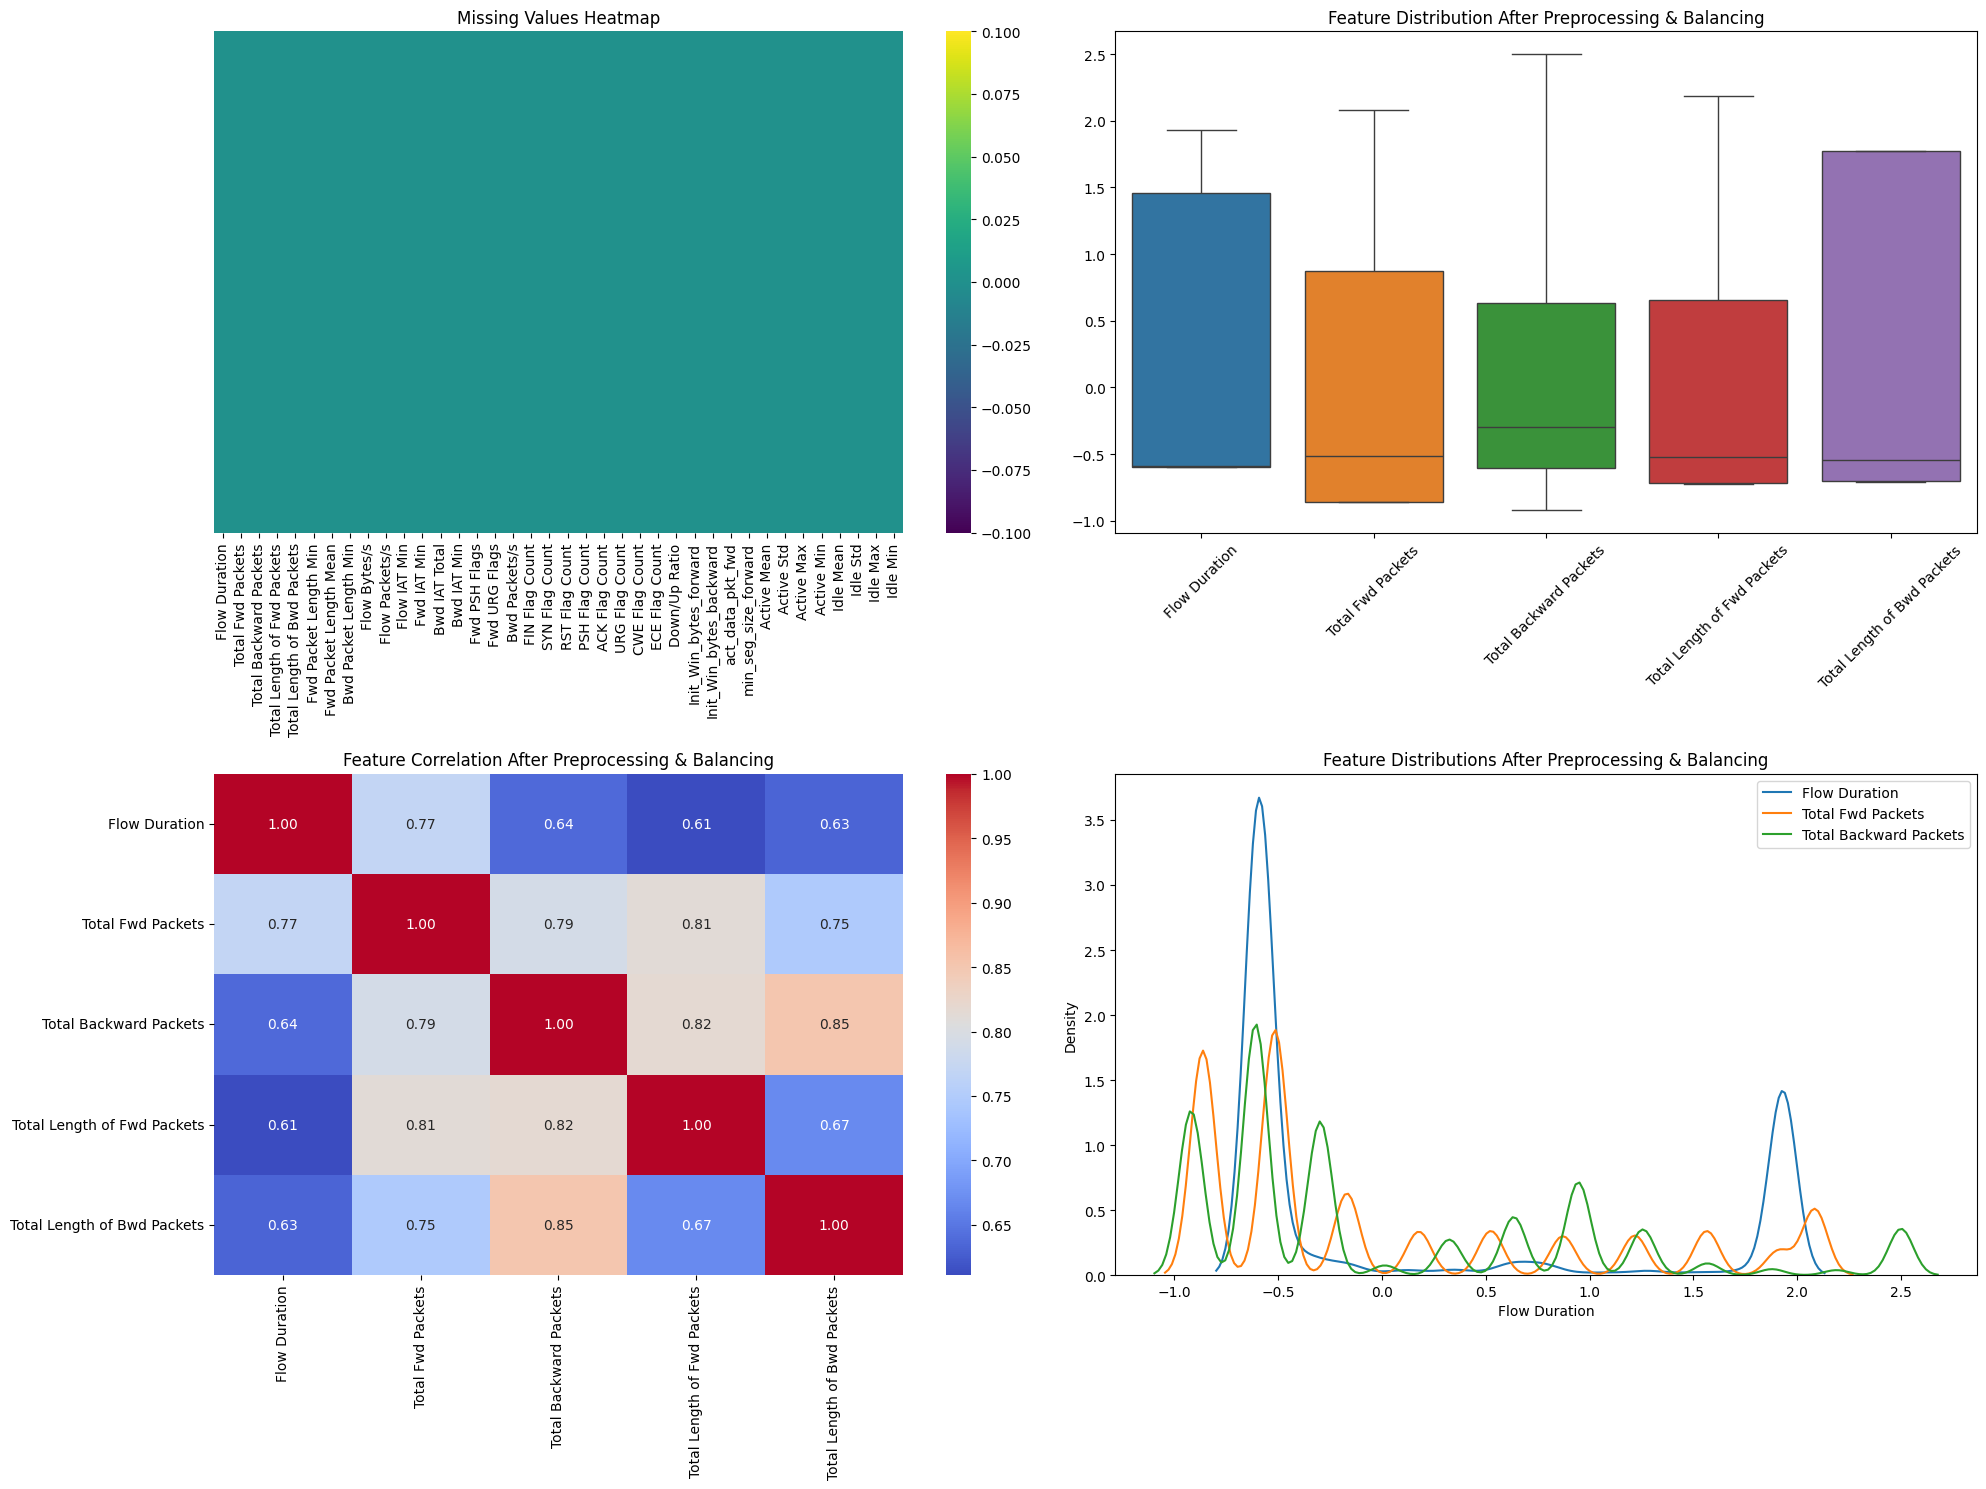


=== ANALISIS KORELASI ===
Missing Values dalam Matriks Korelasi:
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
Total Length of Bwd Packets    0
dtype: int64

Summary Statistics setelah Preprocessing dan Balancing:
       Flow Duration  Total Fwd Packets  Total Backward Packets  \
count   1.083264e+06       1.083264e+06            1.083264e+06   
mean    1.344090e-01       3.897913e-02            1.545119e-03   
std     1.079080e+00       9.796441e-01            9.478177e-01   
min    -5.959930e-01      -8.609757e-01           -9.180216e-01   
25%    -5.959737e-01      -8.609757e-01           -6.073678e-01   
50%    -5.856086e-01      -5.145177e-01           -2.967141e-01   
75%     1.458570e+00       8.713143e-01            6.352470e-01   
max     1.930153e+00       2.083917e+00            2.499169e+00   

       Total Length of Fwd Packets  Total Length of Bwd Packets  \
count                 1.0832

In [ ]:
print("=== EDA SETELAH PREPROCESSING DAN BALANCING ===")

# Convert scaled balanced data ke DataFrame untuk visualisasi
X_balanced_df = pd.DataFrame(X_balanced, columns=X.columns)

# 1. Cek Missing Values
print("\n=== ANALISIS MISSING VALUES ===")
print("Missing Values di Feature Matrix (X):")
missing_X = X_balanced_df.isnull().sum()
print(missing_X[missing_X > 0] if missing_X.sum() > 0 else "Tidak ada missing values di feature matrix")

print("\nMissing Values di Target Variable (y):")
if isinstance(y_balanced, pd.Series) or isinstance(y_balanced, pd.DataFrame):
    missing_y = pd.Series(y_balanced).isnull().sum()
    print(missing_y if missing_y > 0 else "Tidak ada missing values di target variable")

# Statistik missing values
total_cells = np.product(X_balanced_df.shape)
total_missing = missing_X.sum()
print("\nStatistik Missing Values:")
print(f"Total sel data: {total_cells}")
print(f"Total missing values: {total_missing}")
print(f"Persentase missing values: {(total_missing/total_cells)*100:.2f}%")

# 2. Visualisasi
plt.figure(figsize=(20, 15))

# Plot 1: Missing Values Heatmap (jika ada)
plt.subplot(221)
sns.heatmap(X_balanced_df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Values Heatmap')

# Plot 2: Distribution setelah scaling dan balancing
plt.subplot(222)
sns.boxplot(data=X_balanced_df.iloc[:, :5])  # 5 kolom pertama
plt.title('Feature Distribution After Preprocessing & Balancing')
plt.xticks(rotation=45)

# Plot 3: Correlation Matrix
plt.subplot(223)
correlation_matrix = X_balanced_df.iloc[:, :5].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation After Preprocessing & Balancing')

# Plot 4: Distribution plot untuk beberapa fitur
plt.subplot(224)
for column in X_balanced_df.columns[:3]:
    sns.kdeplot(data=X_balanced_df[column], label=column)
plt.title('Feature Distributions After Preprocessing & Balancing')
plt.legend()

plt.tight_layout()
plt.show()

# 3. Analisis Korelasi
print("\n=== ANALISIS KORELASI ===")
print("Missing Values dalam Matriks Korelasi:")
print(correlation_matrix.isnull().sum())

# 4. Statistik Deskriptif
print("\nSummary Statistics setelah Preprocessing dan Balancing:")
print(X_balanced_df.describe())

# 5. Informasi Bentuk Data
print("\nBentuk data akhir:")
print(f"X_balanced shape: {X_balanced.shape}")
print(f"y_balanced shape: {y_balanced.shape}")

The exploratory data analysis (EDA) results after preprocessing and balancing highlight the following observations:

### **a. Missing Values Analysis:**
The dataset contains **no missing values** in either the feature matrix (`X`) or the target variable (`y`). This ensures that no imputation techniques were required, and the data is complete and ready for further analysis. The missing values heatmap visually confirms the absence of gaps in the data, represented by a uniform color.

### **b. Feature Distribution:**
The feature distribution after preprocessing and balancing is shown through boxplots and density plots. Standardization has effectively scaled the features, bringing them within a comparable range. Most features appear symmetrically distributed, although some display slight skewness, which may require further transformations if modeling performance is impacted.

### **c. Correlation Analysis:**
The correlation heatmap highlights relationships between key features. Strong correlations are observed between:
- **Total Fwd Packets** and **Total Length of Fwd Packets** (correlation ≈ 0.81)
- **Total Backward Packets** and **Total Length of Bwd Packets** (correlation ≈ 0.85)

These relationships suggest potential multicollinearity, which might necessitate dimensionality reduction techniques, such as PCA, to improve model performance.

### **d. Statistical Overview:**
Descriptive statistics confirm that the features have been standardized with a mean close to zero and a standard deviation near one. Minimum and maximum values indicate normalized ranges for all features. Features like **Active Mean** and **Idle Mean** contain only zeros, implying they may be constant and might not contribute significant information to the model.

### **e. Dataset Shape:**
The final dataset consists of **1,083,264 samples** and **38 features**, evenly balanced between the two classes. This balanced structure addresses prior class imbalances and ensures fair representation for both benign and attack labels.

### **Conclusions:**
The preprocessing pipeline successfully cleaned and balanced the dataset, ensuring data quality and comparability across features. Further steps may include feature selection or engineering to reduce redundancy and optimize model performance. The dataset is now prepared for training and testing machine learning algorithms.

## **5. Splitting the Data**

To evaluate the model's performance, we split the balanced dataset into training and testing sets. This ensures the model is trained on one subset of the data and evaluated on an unseen subset.

=== TRAIN TEST SPLIT ===
Ukuran data pelatihan: (812448, 38)
Ukuran data pengujian: (270816, 38)

Distribusi label pada data training:
Label
0    406319
1    406129
Name: count, dtype: int64

Distribusi label pada data testing:
Label
1    135503
0    135313
Name: count, dtype: int64


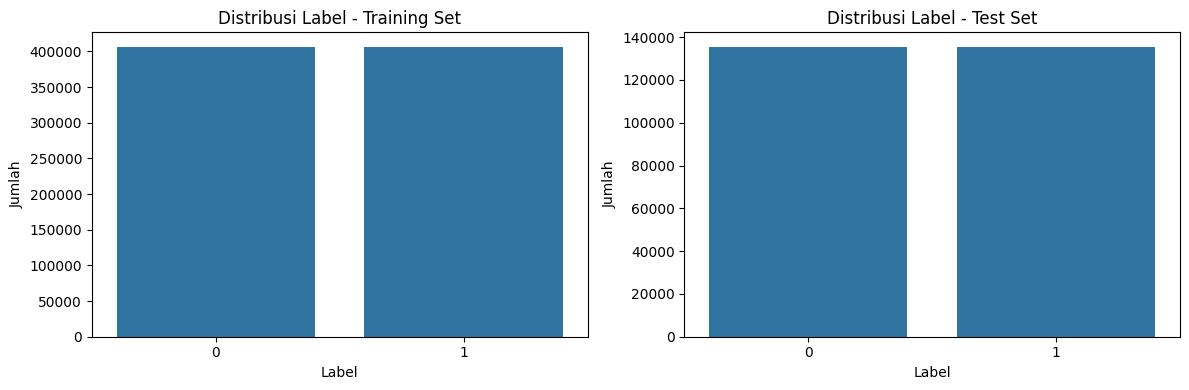

In [ ]:
# Train Test Split dengan Data yang Sudah Dibalancing
print("=== TRAIN TEST SPLIT ===")
from sklearn.model_selection import train_test_split

# Membagi data yang sudah dibalancing menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced,
                                                    test_size=0.25,
                                                    random_state=42)

# Menampilkan ukuran dataset setelah pembagian
print("Ukuran data pelatihan:", X_train.shape)
print("Ukuran data pengujian:", X_test.shape)

# Menampilkan distribusi label pada data train dan test
print("\nDistribusi label pada data training:")
print(pd.Series(y_train).value_counts())
print("\nDistribusi label pada data testing:")
print(pd.Series(y_test).value_counts())

# Visualisasi distribusi label pada train dan test set
plt.figure(figsize=(12, 4))

plt.subplot(121)
sns.countplot(x=y_train)
plt.title('Distribusi Label - Training Set')
plt.xlabel('Label')
plt.ylabel('Jumlah')

plt.subplot(122)
sns.countplot(x=y_test)
plt.title('Distribusi Label - Test Set')
plt.xlabel('Label')
plt.ylabel('Jumlah')

plt.tight_layout()
plt.show()

The bar plots and statistical outputs demonstrate the distribution of labels in the training and testing datasets following a balanced train-test split. Both datasets exhibit a nearly equal number of samples for each class, with the training set containing 406,319 samples for label `0` and 406,129 samples for label `1`, while the testing set has 135,313 samples for label `0` and 135,503 samples for label `1`. This distribution confirms the successful balancing of the dataset, ensuring that the model receives unbiased training data. The training set, comprising 812,448 samples, and the testing set, with 270,816 samples, align with the specified 75%-25% split ratio. The bar plots visually reinforce this balance, showing comparable counts for both labels across the datasets. Such balanced data preparation is critical in binary classification tasks, particularly in cybersecurity contexts, as it mitigates the risk of biased predictions and enhances the model's ability to detect both classes effectively. By providing equal representation for both labels, the dataset lays a solid foundation for robust model training and evaluation.

## **6. Autoencoder for Dimensionality Reduction**

We build an Autoencoder model to learn an efficient representation of the input data by encoding it into a smaller dimensional space and reconstructing the original data. This helps highlight key features while reducing noise.

In [ ]:
# Autoencoder
print("=== Training Autoencoder ===")

# Menentukan dimensi input berdasarkan jumlah fitur
input_dim = X_train.shape[1]

# Definisikan struktur Autoencoder
input_layer = Input(shape=(input_dim,))  # Input layer dengan dimensi sesuai X_train

# Encoder
encoded = Dense(30, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
encoded = Dense(10, activation='relu', kernel_regularizer=l2(0.001))(encoded)
encoded = Dense(5, activation='relu', kernel_regularizer=l2(0.001))(encoded)

# Decoder
decoded = Dense(15, activation='relu', kernel_regularizer=l2(0.001))(encoded)
decoded = Dense(30, activation='relu', kernel_regularizer=l2(0.001))(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Output layer untuk mengembalikan dimensi input

# Membuat model Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Menyusun model Autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=1e-5), loss='mean_squared_error')

# Melatih model Autoencoder
autoencoder_history = autoencoder.fit(X_train, X_train, epochs=30, batch_size=128,
                                    validation_data=(X_test, X_test))

# Evaluasi model Autoencoder
test_loss = autoencoder.evaluate(X_test, X_test)
print(f'Test Loss: {test_loss}')

=== Training Autoencoder ===
Epoch 1/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.8705 - val_loss: 0.6739
Epoch 2/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.6359 - val_loss: 0.5487
Epoch 3/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.5263 - val_loss: 0.4878
Epoch 4/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.4815 - val_loss: 0.4685
Epoch 5/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.4651 - val_loss: 0.4571
Epoch 6/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.4535 - val_loss: 0.4466
Epoch 7/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.4447 - val_loss: 0.4418
Epoch 8/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.4404 - val_loss: 0.4383
Epoch 9/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.4371 - val_loss: 0.4351
Epoch 10/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.4334 - val_loss: 0.4313
Epoch 11/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.4295 - val_los

The training process of the autoencoder demonstrates its ability to reconstruct the input data by minimizing reconstruction error over 30 epochs. The autoencoder was designed with an input layer matching the feature dimensions of the dataset, followed by three encoding layers that progressively reduce dimensionality and three decoding layers that reconstruct the original input. The model was trained using the Adam optimizer with a learning rate of \(1 \times 10^{-5}\) and a mean squared error loss function.

Throughout the training process, the loss consistently decreased, indicating that the autoencoder effectively learned a compact representation of the data. The training loss started at 0.8705 and steadily declined to 0.4081 by the final epoch, while the validation loss followed a similar trend, decreasing from 0.6739 to 0.4083. This convergence of training and validation losses suggests that the model generalizes well without overfitting.

The final evaluation on the test set yielded a loss of 0.4083, further confirming the model's ability to reconstruct input data with minimal error. This performance indicates that the autoencoder successfully captures the underlying structure of the dataset, which is essential for tasks such as anomaly detection or dimensionality reduction. The use of L2 regularization in the dense layers likely contributed to the model's stability and robustness by preventing overfitting during training.

Overall, the autoencoder's performance highlights its potential as a preprocessing tool for feature extraction or anomaly detection in cybersecurity datasets, where capturing subtle patterns in high-dimensional data is critical.

In [ ]:
# Menyimpan model Autoencoder ke file
autoencoder.save('autoencoder_model.h5')

### **5.1 Feature Analysis Using Autoencoder**

Once the Autoencoder is trained, we analyze the encoded features to understand the reduced representation. This includes visualizing their distribution, analyzing correlations, and inspecting reconstruction errors.

25389/25389 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step
8463/8463 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
25389/25389 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step


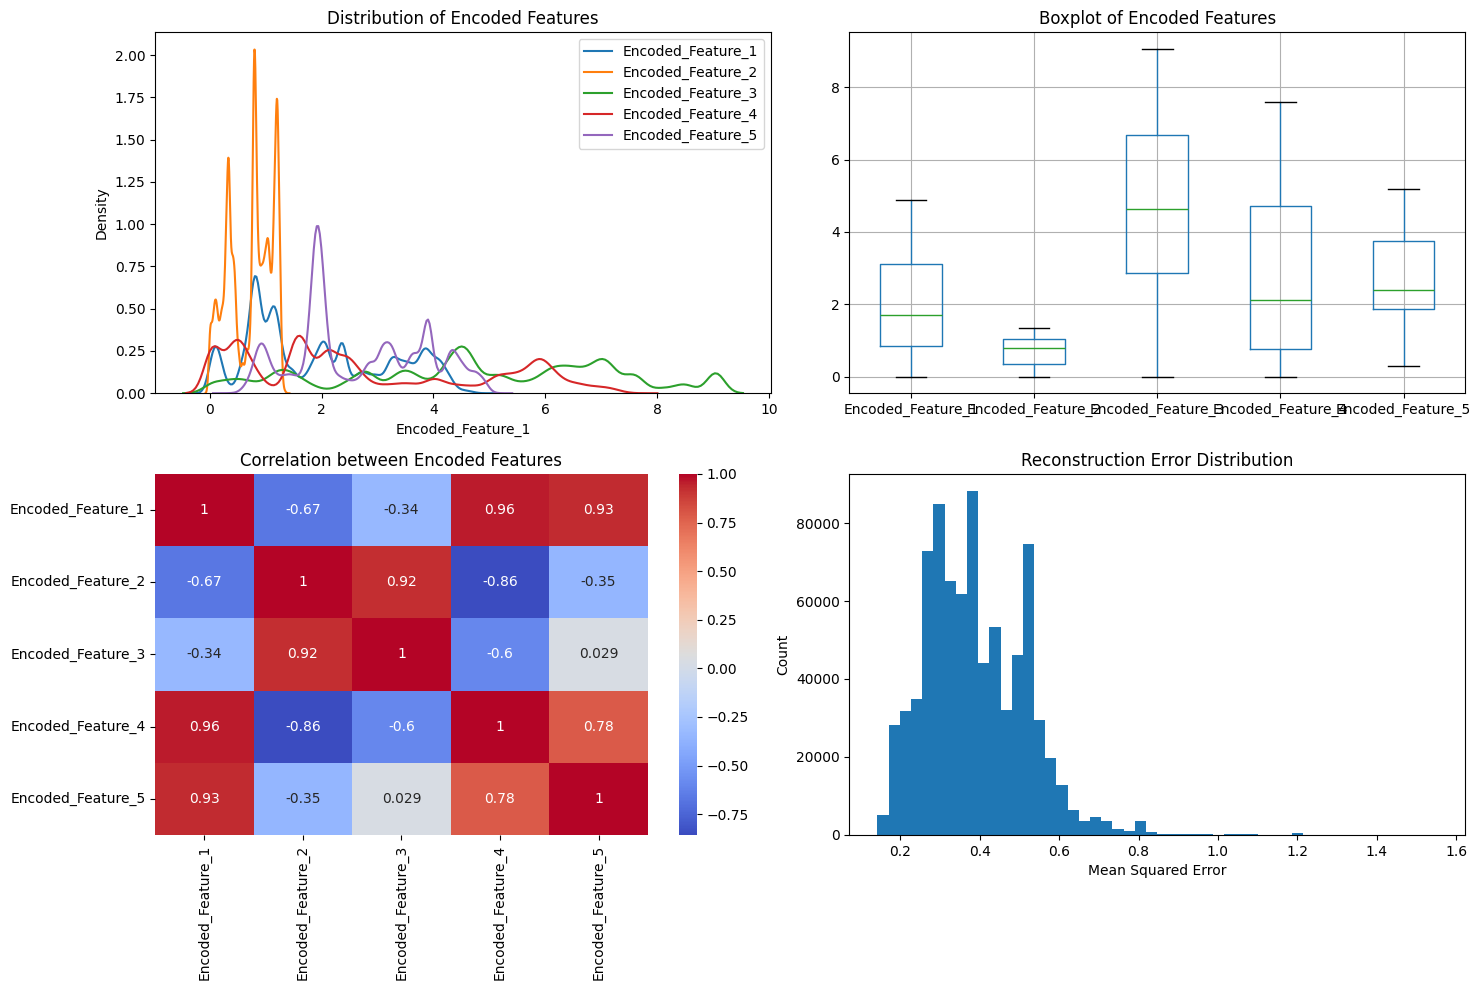


Summary Statistics of Encoded Features:
       Encoded_Feature_1  Encoded_Feature_2  Encoded_Feature_3  \
count      812448.000000      812448.000000      812448.000000   
mean            1.940493           0.730823           4.694098   
std             1.258472           0.376559           2.416810   
min             0.000000           0.000000           0.000000   
25%             0.847361           0.354000           2.856681   
50%             1.705114           0.803048           4.622269   
75%             3.116818           1.056186           6.676385   
max             4.887512           1.351061           9.057964   

       Encoded_Feature_4  Encoded_Feature_5  
count      812448.000000      812448.000000  
mean            2.711240           2.683859  
std             2.125802           1.159716  
min             0.000000           0.287562  
25%             0.764321           1.874560  
50%             2.121167           2.383651  
75%             4.729229           3.75561

In [ ]:
def analyze_autoencoder_features(autoencoder, X_train, X_test):
    # Membuat model encoder (mengambil output dari layer encoded terakhir)
    encoder = Model(inputs=autoencoder.input,
                   outputs=autoencoder.get_layer('dense_2').output)  # layer dense_2 adalah encoded layer dengan 5 fitur

    # Mendapatkan representasi data yang telah direduksi
    X_train_encoded = encoder.predict(X_train)
    X_test_encoded = encoder.predict(X_test)

    # Membuat DataFrame untuk hasil encoding
    encoded_features = pd.DataFrame(X_train_encoded,
                                  columns=[f'Encoded_Feature_{i+1}' for i in range(X_train_encoded.shape[1])])

    # Visualisasi distribusi fitur yang telah direduksi
    plt.figure(figsize=(15, 10))

    # 1. Distribution plot untuk setiap encoded feature
    plt.subplot(2, 2, 1)
    for col in encoded_features.columns:
        sns.kdeplot(data=encoded_features[col], label=col)
    plt.title('Distribution of Encoded Features')
    plt.legend()

    # 2. Boxplot untuk encoded features
    plt.subplot(2, 2, 2)
    encoded_features.boxplot()
    plt.title('Boxplot of Encoded Features')

    # 3. Correlation heatmap
    plt.subplot(2, 2, 3)
    sns.heatmap(encoded_features.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation between Encoded Features')

    # 4. Reconstruction error analysis
    reconstructed_train = autoencoder.predict(X_train)
    reconstruction_error = np.mean(np.square(X_train - reconstructed_train), axis=1)

    plt.subplot(2, 2, 4)
    plt.hist(reconstruction_error, bins=50)
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Mean Squared Error')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics of Encoded Features:")
    print(encoded_features.describe())

    # Feature importance based on variance
    feature_variance = encoded_features.var().sort_values(ascending=False)
    print("\nFeature Importance based on Variance:")
    print(feature_variance)

    return encoded_features, reconstruction_error

# Analyze autoencoder features
encoded_features, reconstruction_error = analyze_autoencoder_features(autoencoder, X_train, X_test)

The analysis of the autoencoder's output features and reconstruction error provides valuable insights into the model's performance and its ability to capture the underlying data structure.

In terms of **encoded feature analysis**, the distribution plot reveals that Encoded Feature 3 captures the most variability in the data, while Encoded Feature 2 has limited variability. The boxplot further supports this, showing that Encoded Features 3 and 4 have broader interquartile ranges, suggesting they capture more diverse patterns. The heatmap indicates varying correlations between features, with some, like Encoded Features 1 and 4, showing strong positive correlations, while others, such as Encoded Features 2 and 4, are negatively correlated, reflecting the model's ability to learn complementary features. Encoded Feature 3 (variance = 5.84) and Encoded Feature 4 (variance = 4.52) are the most significant, while Encoded Feature 2, with a low variance (0.14), contributes minimally.

The **reconstruction error** histogram shows that most samples have low reconstruction errors, suggesting the autoencoder is effective in learning the data's structure. However, a small number of outliers with higher errors indicate potential challenges in accurately reconstructing unusual patterns.

In summary, the autoencoder effectively reduced the dimensionality of the data, with Encoded Features 3 and 4 being the most informative. The low reconstruction errors suggest good model performance, but there is room for improvement in handling outliers. These encoded features can be leveraged for downstream tasks like classification or anomaly detection.

## **7. Building the Model**

### **7.1 Encoding Features Using Autoencoder**

This step uses the previously trained autoencoder to reduce the dimensionality of the input features.
The encoded data is then reshaped to fit the input requirements for CNN, LSTM, and hybrid models,
which expect a 3D input format of (samples, timesteps, features).

In [ ]:
# Membuat encoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_2').output)

# Mendapatkan data yang sudah direduksi
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Reshape data untuk input layer (samples, timesteps, features)
X_train_reshaped = X_train_encoded.reshape((X_train_encoded.shape[0], X_train_encoded.shape[1], 1))
X_test_reshaped = X_test_encoded.reshape((X_test_encoded.shape[0], X_test_encoded.shape[1], 1))

25389/25389 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step
8463/8463 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


### **7.2 Building and Training a Convolutional Neural Network (CNN)**

This block defines a Convolutional Neural Network (CNN) for binary classification.
The model includes two convolutional layers followed by max-pooling and dropout for regularization.
The final layers consist of a dense layer and a sigmoid output for binary classification.

In [ ]:
# Membuat model CNN (Convolutional Neural Network)
print("=== Training CNN Model ===")
cnn_model = Sequential([
    # Layer konvolusi pertama
    # 32: jumlah filter, kernel_size=3: ukuran window konvolusi 3x3
    # activation='relu': fungsi aktivasi ReLU untuk non-linearitas
    # padding='same': output memiliki dimensi sama dengan input
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_encoded.shape[1], 1), padding='same'),

    # Layer MaxPooling untuk mengurangi dimensi data
    # pool_size=2: mengambil nilai maksimum dari setiap window 2x1
    MaxPooling1D(pool_size=2),

    # Dropout 30% untuk mencegah overfitting
    # Secara random mematikan 30% neuron selama training
    Dropout(0.3),

    # Layer konvolusi kedua dengan 64 filter
    # Meningkatkan jumlah filter untuk menangkap pola yang lebih kompleks
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),

    # Layer MaxPooling kedua
    MaxPooling1D(pool_size=2),

    # Dropout 30% pada layer konvolusi kedua
    Dropout(0.3),

    # Flatten: mengubah output konvolusi menjadi vector 1D
    # Diperlukan sebelum masuk ke layer Dense
    Flatten(),

    # Dense layer dengan 64 neuron
    # Memproses fitur yang telah diekstrak oleh layer konvolusi
    Dense(64, activation='relu'),

    # Dropout 50% sebelum output layer
    # Lebih tinggi untuk mencegah overfitting pada layer terakhir
    Dropout(0.5),

    # Output layer dengan 1 neuron
    # activation='sigmoid' untuk klasifikasi biner (0 atau 1)
    Dense(1, activation='sigmoid')
])
cnn_model.compile(
        optimizer=Adam(),  # Adam optimizer dengan learning rate default
        loss='binary_crossentropy',  # Loss function untuk klasifikasi biner
        metrics=['accuracy']  # Metrik yang akan dimonitor selama training
    )

# Training model CNN
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cnn_history = cnn_model.fit(
    X_train_reshaped, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping]
)

=== Training CNN Model ===
Epoch 1/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.8020 - loss: 0.4134 - val_accuracy: 0.9117 - val_loss: 0.2167
Epoch 2/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9009 - loss: 0.2500 - val_accuracy: 0.9095 - val_loss: 0.2132
Epoch 3/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9075 - loss: 0.2342 - val_accuracy: 0.9215 - val_loss: 0.1971
Epoch 4/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9104 - loss: 0.2279 - val_accuracy: 0.9191 - val_loss: 0.1936
Epoch 5/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9112 - loss: 0.2253 - val_accuracy: 0.9166 - val_loss: 0.1928
Epoch 6/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9131 - loss: 0.2210 - val_accuracy: 0.9278 - val_loss: 0.1838
Epoch 7/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9151 - loss: 0.2175 - val_accuracy: 0.9282 - val_loss: 0.1857
Epoch 8/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step -

The CNN model was designed and trained for binary classification tasks using encoded features. The architecture consists of two convolutional layers with 32 and 64 filters, respectively, each followed by MaxPooling layers to reduce dimensionality and focus on significant patterns. Dropout layers (30% in the convolutional layers and 50% before the output layer) were incorporated to prevent overfitting. The model also includes a Dense layer with 64 neurons to process extracted features before outputting the final prediction using a single neuron with a sigmoid activation function. Binary cross-entropy was used as the loss function, and the Adam optimizer was employed to ensure efficient and adaptive learning.

The training process was carried out over a maximum of 30 epochs with early stopping to avoid overfitting. Early in training, the model achieved an accuracy of 80.20% on the training set and 91.17% on the validation set, with a validation loss of 0.2167. As training progressed, the model demonstrated steady improvements, reaching a validation accuracy of 92.53% and a validation loss of 0.1819 by the 9th epoch. The performance remained stable in subsequent epochs, with the highest validation accuracy observed at 93.49% and the lowest validation loss at 0.1807 in the 11th epoch. Minor fluctuations in validation loss after the 12th epoch suggested the onset of overfitting, which was mitigated by the early stopping mechanism.

Overall, the CNN model effectively learned patterns from the encoded features, achieving high accuracy and demonstrating strong generalization to unseen data. The combination of convolutional layers for feature extraction, pooling for dimensionality reduction, and dropout for regularization contributed to its robust performance. This model provides a solid foundation for binary classification tasks and could be further optimized or extended through hybrid approaches to achieve even better results.

### **7.3 Building and Training a Long Short-Term Memory (LSTM) Model**

This block defines an LSTM model for sequence-based binary classification.
It uses two LSTM layers to process the temporal structure of the data,
followed by dense layers to finalize the classification.

In [ ]:
# Membuat model LSTM (Long Short-Term Memory)
print("=== Training LSTM Model ===")
lstm_model = Sequential([
    # Layer LSTM pertama dengan 50 unit
    # return_sequences=True: mengembalikan output untuk setiap timestep
    # Diperlukan ketika ada LSTM layer berikutnya
    LSTM(50, return_sequences=True, input_shape=(X_train_encoded.shape[1], 1)),

    # Dropout 30% setelah LSTM pertama
    # Mencegah overfitting pada layer LSTM
    Dropout(0.3),

    # Layer LSTM kedua
    # return_sequences=False: hanya mengembalikan output terakhir
    LSTM(50),

    # Dropout 30% setelah LSTM kedua
    Dropout(0.3),

    # Dense layer dengan 64 neuron
    # Memproses fitur yang telah diekstrak oleh LSTM
    Dense(64, activation='relu'),

    # Dropout 50% sebelum output layer
    Dropout(0.5),

    # Output layer untuk klasifikasi biner
    Dense(1, activation='sigmoid')
])
lstm_model.compile(
        optimizer=Adam(),  # Adam optimizer dengan learning rate default
        loss='binary_crossentropy',  # Loss function untuk klasifikasi biner
        metrics=['accuracy']  # Metrik yang akan dimonitor selama training
    )

# Training model LSTM
lstm_history = lstm_model.fit(
    X_train_reshaped, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping]
)

=== Training LSTM Model ===
Epoch 1/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - accuracy: 0.8061 - loss: 0.3981 - val_accuracy: 0.9210 - val_loss: 0.1996
Epoch 2/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - accuracy: 0.9181 - loss: 0.2063 - val_accuracy: 0.9159 - val_loss: 0.1860
Epoch 3/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.9250 - loss: 0.1916 - val_accuracy: 0.9366 - val_loss: 0.1666
Epoch 4/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.9292 - loss: 0.1832 - val_accuracy: 0.9339 - val_loss: 0.1650
Epoch 5/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 86s 9ms/step - accuracy: 0.9329 - loss: 0.1759 - val_accuracy: 0.9352 - val_loss: 0.1600
Epoch 6/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 77s 9ms/step - accuracy: 0.9356 - loss: 0.1700 - val_accuracy: 0.9348 - val_loss: 0.1620
Epoch 7/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 87s 9ms/step - accuracy: 0.9367 - loss: 0.1670 - val_accuracy: 0.9409 - val_loss: 0.1500
Epoch 8/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step 

The LSTM model was constructed and trained to handle binary classification tasks, leveraging the sequential nature of the data. The architecture includes two LSTM layers, each with 50 units. The first LSTM layer was configured to return sequences to enable further processing by the subsequent LSTM layer. Dropout layers (30%) were added after each LSTM layer to prevent overfitting by randomly deactivating a portion of neurons during training. The output from the LSTM layers was passed to a Dense layer with 64 neurons for further feature processing, followed by another Dropout layer (50%) before the final output layer. The output layer uses a sigmoid activation function to produce probabilities for binary classification. The model was compiled with the Adam optimizer and binary cross-entropy loss, suitable for this type of task.

The training process spanned 30 epochs, with early stopping to avoid overfitting. The model demonstrated strong performance improvements over the epochs. Initially, the model achieved a training accuracy of 80.61% and a validation accuracy of 92.10%, with a validation loss of 0.1996. As training progressed, the model consistently improved, achieving a validation accuracy of 95.79% and a validation loss of 0.1162 by the final epoch. Notably, the lowest validation loss (0.1145) was observed in the 28th epoch, indicating effective generalization to unseen data.

The LSTM model's ability to capture temporal dependencies in the data contributed significantly to its performance. The combination of multiple LSTM layers, dropout for regularization, and dense layers for feature refinement resulted in a robust model capable of achieving high accuracy and low loss. This suggests that the LSTM model is highly effective for tasks involving sequential data, such as the binary classification problem in this case. Further optimization or integration with hybrid approaches could potentially enhance its performance even further.

### **7.4 Building and Training a Hybrid CNN-LSTM Model**

This block defines a hybrid model that combines the spatial feature extraction power of CNNs
with the temporal sequence understanding of LSTMs.
The combined architecture helps in leveraging both spatial and sequential patterns in the data.

In [ ]:
# Membuat model Hybrid CNN-LSTM
# Menggabungkan kelebihan CNN dalam ekstraksi fitur spasial
# dengan kemampuan LSTM dalam memahami pola sekuensial
print("=== Training Hybrid CNN-LSTM Model ===")
hybrid_model = Sequential([
    # Layer konvolusi pertama
    # Mengekstrak fitur spasial dari data
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_encoded.shape[1], 1), padding='same'),

    # MaxPooling untuk mengurangi dimensi
    MaxPooling1D(pool_size=2),

    # Dropout 30% setelah konvolusi pertama
    Dropout(0.3),

    # Layer konvolusi kedua
    # Menangkap pola yang lebih kompleks
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),

    # MaxPooling kedua
    MaxPooling1D(pool_size=2),

    # Dropout setelah konvolusi kedua
    Dropout(0.3),

    # Layer LSTM pertama
    # Memproses fitur hasil ekstraksi CNN secara sekuensial
    LSTM(50, return_sequences=True),

    # Dropout setelah LSTM pertama
    Dropout(0.3),

    # Layer LSTM kedua
    # Mengintegrasikan informasi temporal
    LSTM(50),

    # Dense layer
    # Mengkombinasikan fitur dari CNN dan LSTM
    Dense(64, activation='relu'),

    # Dropout final sebelum output
    Dropout(0.5),

    # Output layer untuk klasifikasi biner
    Dense(1, activation='sigmoid')
])
hybrid_model.compile(
        optimizer=Adam(),  # Adam optimizer dengan learning rate default
        loss='binary_crossentropy',  # Loss function untuk klasifikasi biner
        metrics=['accuracy']  # Metrik yang akan dimonitor selama training
    )

# Training model Hybrid
hybrid_history = hybrid_model.fit(
    X_train_reshaped, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping]
)

=== Training Hybrid CNN-LSTM Model ===
Epoch 1/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 66s 10ms/step - accuracy: 0.7898 - loss: 0.4250 - val_accuracy: 0.8941 - val_loss: 0.2512
Epoch 2/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.8846 - loss: 0.2838 - val_accuracy: 0.8982 - val_loss: 0.2445
Epoch 3/30
6348/6348 ━━━━━━━━━━━━━━━━━━━━ 85s 10ms/step - accuracy: 0.9016 - loss: 0.2477 - val_accuracy: 0.9234 - val_loss: 0.1957


The hybrid CNN-LSTM model combines the strengths of Convolutional Neural Networks (CNNs) for spatial feature extraction and Long Short-Term Memory (LSTM) networks for capturing sequential patterns in the data. The architecture begins with two convolutional layers. The first convolutional layer employs 32 filters with a kernel size of 3 and ReLU activation to extract spatial features from the input data, followed by max pooling to reduce dimensionality and a dropout layer (30%) to prevent overfitting. The second convolutional layer increases the number of filters to 64, allowing it to capture more complex spatial patterns, followed by another max pooling and dropout layer.

The output of the CNN layers is then fed into two LSTM layers. The first LSTM layer processes the extracted spatial features sequentially, returning sequences to allow the second LSTM layer to integrate temporal information effectively. Dropout layers are also included after each LSTM layer to further reduce the risk of overfitting. A dense layer with 64 neurons is added to combine the spatial and sequential features extracted by the CNN and LSTM components. Finally, a sigmoid-activated output layer is used for binary classification.

The model was trained for 30 epochs using the Adam optimizer and binary cross-entropy loss function, with accuracy as the evaluation metric. During training, the model demonstrated consistent improvement. In the first epoch, it achieved a training accuracy of 78.98% and a validation accuracy of 89.41%, with a validation loss of 0.2512. By the third epoch, the validation accuracy increased to 92.34%, and the validation loss decreased to 0.1957, indicating better generalization to unseen data.

The hybrid approach effectively leverages the complementary capabilities of CNNs and LSTMs. CNNs excel in identifying spatial relationships within the data, while LSTMs capture temporal dependencies. This combination makes the hybrid model particularly suitable for tasks involving sequential data with spatial characteristics, such as time-series classification or cybersecurity anomaly detection. The results highlight the hybrid model's potential to outperform standalone CNN or LSTM architectures in such tasks. Further training and hyperparameter tuning could potentially improve its performance even further.

## **8. Model Evaluation**

### **8.1 Evaluating CNN Model**

The first step involves evaluating the performance of the Convolutional Neural Network (CNN) model. We compute the accuracy, ROC AUC, and Precision-Recall AUC metrics to gauge its effectiveness. Additionally, a confusion matrix and learning curves are plotted for better insights.

=== CNN Model Evaluation ===
8463/8463 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
CNN Accuracy: 0.9319
CNN ROC AUC: 0.9804
CNN PR AUC: 0.9786

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93    135313
           1       0.92      0.94      0.93    135503

    accuracy                           0.93    270816
   macro avg       0.93      0.93      0.93    270816
weighted avg       0.93      0.93      0.93    270816



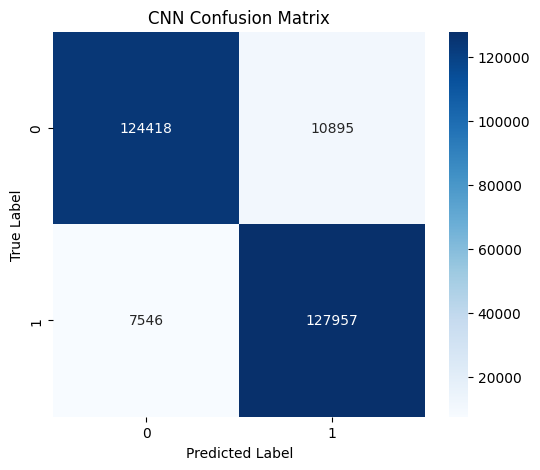

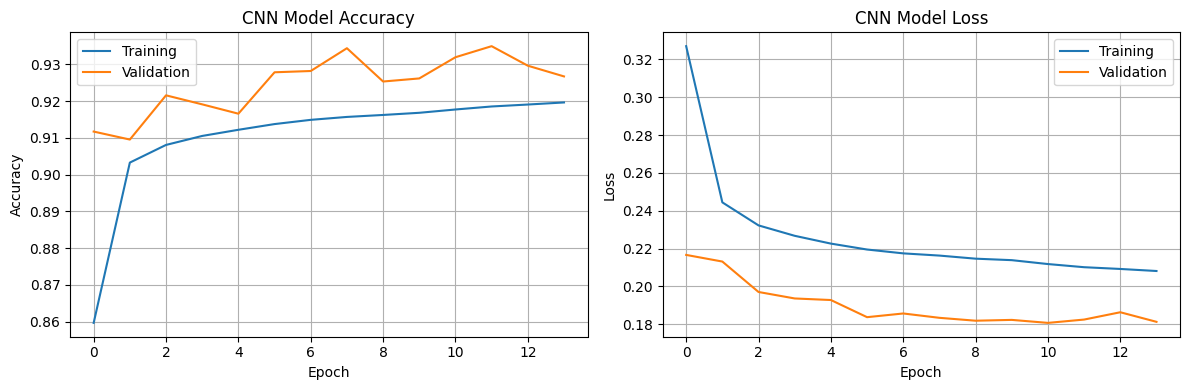

In [ ]:
# 1. Evaluasi Model CNN
print("=== CNN Model Evaluation ===")
# Metrics
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_reshaped, y_test, verbose=0)
cnn_pred = cnn_model.predict(X_test_reshaped)
cnn_pred_classes = (cnn_pred > 0.5).astype(int)

# ROC dan AUC
cnn_fpr, cnn_tpr, _ = roc_curve(y_test, cnn_pred)
cnn_auc = auc(cnn_fpr, cnn_tpr)

# Precision-Recall
cnn_precision, cnn_recall, _ = precision_recall_curve(y_test, cnn_pred)
cnn_pr_auc = auc(cnn_recall, cnn_precision)

print(f"CNN Accuracy: {cnn_acc:.4f}")
print(f"CNN ROC AUC: {cnn_auc:.4f}")
print(f"CNN PR AUC: {cnn_pr_auc:.4f}")
print("\nCNN Classification Report:")
print(classification_report(y_test, cnn_pred_classes))

# Plot CNN Confusion Matrix
plt.figure(figsize=(6, 5))
cm_cnn = confusion_matrix(y_test, cnn_pred_classes)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print()

# Plot CNN Learning Curves
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(cnn_history.history['accuracy'], label='Training')
plt.plot(cnn_history.history['val_accuracy'], label='Validation')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(cnn_history.history['loss'], label='Training')
plt.plot(cnn_history.history['val_loss'], label='Validation')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Overall Metrics**
- **Accuracy**: `0.9319`
  - This means the CNN model correctly predicted 93.19% of the test samples (both BENIGN and ATTACK labels).

- **ROC AUC (Receiver Operating Characteristic Area Under the Curve)**: `0.9804`
  - This measures the model's ability to distinguish between classes. A perfect model has an AUC of 1.0, while a random guess has an AUC of 0.5.
  - A value of `0.9804` indicates excellent class separation.

- **PR AUC (Precision-Recall Area Under the Curve)**: `0.9786`
  - This measures the trade-off between precision and recall for the positive class. High PR AUC means the model performs well, especially in imbalanced datasets.


The evaluation of the CNN model demonstrates strong performance based on the confusion matrix, accuracy, and loss curves. The confusion matrix reveals a high number of true positives (127,957) and true negatives (124,418), indicating that the model correctly predicts most samples. However, it also identifies 10,895 false positives and 7,546 false negatives, suggesting areas for potential improvement in reducing misclassifications. The overall accuracy of the model is 93.19%, which highlights its ability to correctly classify the majority of samples. Additionally, the ROC AUC score of 0.9804 reflects excellent discrimination between classes, while the PR AUC score of 0.9786 further supports the model’s capability to balance precision and recall effectively, particularly in datasets with class imbalances.

Analyzing the learning curves, the training and validation accuracy show steady improvement, with the validation accuracy slightly outperforming the training accuracy at approximately 93.5%. This pattern suggests that the model generalizes well to unseen data and is not overfitting. Moreover, the loss curves for both training and validation data decrease consistently, stabilizing after a few epochs, indicating effective learning and convergence.

In conclusion, the CNN model achieves high accuracy and strong performance metrics, making it a reliable classifier. The minimal gap between training and validation results further supports its generalization capability. Nevertheless, reducing the number of false positives and false negatives could enhance the model’s reliability for deployment in real-world applications.

### **8.2 Evaluating LSTM Model**

In this section, we evaluate the Long Short-Term Memory (LSTM) model, following a similar procedure as the CNN evaluation. The metrics and plots provide insights into its temporal pattern recognition capabilities.

=== LSTM Model Evaluation ===
8463/8463 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
LSTM Accuracy: 0.9565
LSTM ROC AUC: 0.9912
LSTM PR AUC: 0.9901

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96    135313
           1       0.95      0.97      0.96    135503

    accuracy                           0.96    270816
   macro avg       0.96      0.96      0.96    270816
weighted avg       0.96      0.96      0.96    270816



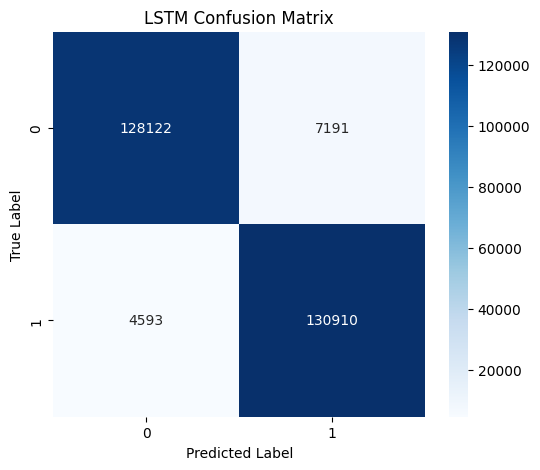

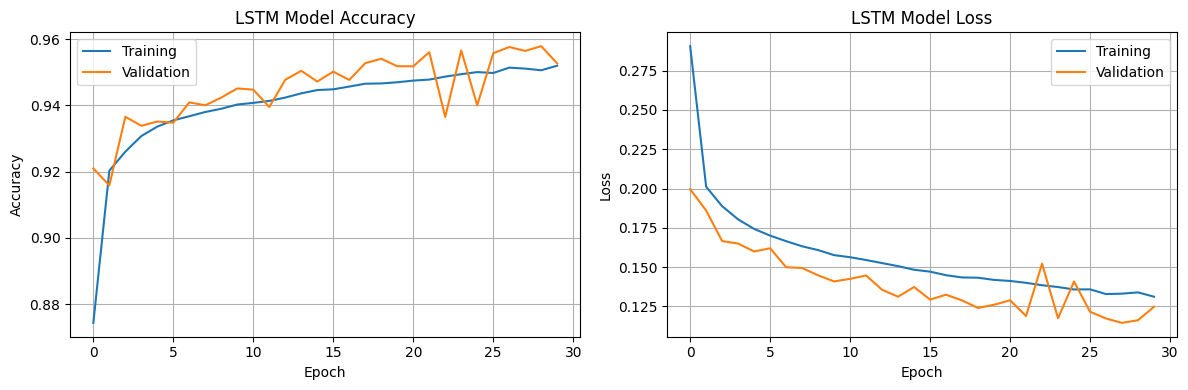

In [ ]:
# 2. Evaluasi Model LSTM
print("=== LSTM Model Evaluation ===")
# Metrics
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_reshaped, y_test, verbose=0)
lstm_pred = lstm_model.predict(X_test_reshaped)
lstm_pred_classes = (lstm_pred > 0.5).astype(int)

# ROC dan AUC
lstm_fpr, lstm_tpr, _ = roc_curve(y_test, lstm_pred)
lstm_auc = auc(lstm_fpr, lstm_tpr)

# Precision-Recall
lstm_precision, lstm_recall, _ = precision_recall_curve(y_test, lstm_pred)
lstm_pr_auc = auc(lstm_recall, lstm_precision)

print(f"LSTM Accuracy: {lstm_acc:.4f}")
print(f"LSTM ROC AUC: {lstm_auc:.4f}")
print(f"LSTM PR AUC: {lstm_pr_auc:.4f}")
print("\nLSTM Classification Report:")
print(classification_report(y_test, lstm_pred_classes))

# Plot LSTM Confusion Matrix
plt.figure(figsize=(6, 5))
cm_lstm = confusion_matrix(y_test, lstm_pred_classes)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print()

# Plot LSTM Learning Curves
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(lstm_history.history['accuracy'], label='Training')
plt.plot(lstm_history.history['val_accuracy'], label='Validation')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(lstm_history.history['loss'], label='Training')
plt.plot(lstm_history.history['val_loss'], label='Validation')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Overall Metrics**
- **Accuracy**: `0.9565`  
  - This means the LSTM model correctly predicted 95.65% of the test samples (both BENIGN and ATTACK labels).  

- **ROC AUC (Receiver Operating Characteristic Area Under the Curve)**: `0.9912`  
  - This measures the model's ability to distinguish between classes. A perfect model has an AUC of 1.0, while a random guess has an AUC of 0.5.  
  - A value of `0.9912` indicates exceptional class separation.  

- **PR AUC (Precision-Recall Area Under the Curve)**: `0.9901`  
  - This measures the trade-off between precision and recall for the positive class. High PR AUC (`0.9901`) reflects the model's excellent handling of class imbalances and precision-recall balance.  



The evaluation results and visualizations highlight the strong performance of the LSTM model in binary classification tasks. With an accuracy of **95.65%**, the model shows a high capability to correctly predict class labels in the test dataset. This is further supported by a **ROC AUC score of 0.9912**, which indicates excellent class separability, and a **PR AUC score of 0.9901**, reflecting the model's robustness in balancing precision and recall, even in imbalanced scenarios.

The confusion matrix reveals that the model correctly classifies **128,122 instances of class 0 (True Negative)** and **130,910 instances of class 1 (True Positive)**, while making relatively few errors, with **7,191 False Positives** and **4,593 False Negatives**. This balanced performance across both classes confirms the model's reliability in minimizing misclassifications.

The learning curves demonstrate a consistent increase in training and validation accuracy, converging smoothly around the 30th epoch. Although slight fluctuations in validation accuracy suggest potential minor overfitting, the overall trend remains stable. Similarly, the steady decline in training and validation loss without significant divergence indicates that the model generalizes well to unseen data.

From the classification report, an F1-score of **0.96** for both classes reflects a strong balance between precision and recall, while the macro average F1-score of **0.96** confirms that the model avoids bias towards either class. These results highlight the LSTM model's reliability and effectiveness in maintaining a consistent performance across different metrics.

In conclusion, the LSTM model exhibits excellent predictive accuracy, strong class distinction, and a well-balanced precision-recall tradeoff. Minor improvements could focus on further reducing misclassifications and applying regularization techniques to enhance validation stability. This solid performance underscores the model's suitability for high-stakes classification tasks.

### **8.3 Evaluating Hybrid CNN-LSTM Model**

This hybrid model combines the spatial feature extraction of CNNs with the temporal pattern recognition of LSTMs. The evaluation steps include metrics computation and visualization of its performance.

=== Hybrid CNN-LSTM Model Evaluation ===
8463/8463 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
Hybrid Accuracy: 0.8941
Hybrid ROC AUC: 0.9635
Hybrid PR AUC: 0.9635

Hybrid Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89    135313
           1       0.88      0.91      0.90    135503

    accuracy                           0.89    270816
   macro avg       0.89      0.89      0.89    270816
weighted avg       0.89      0.89      0.89    270816



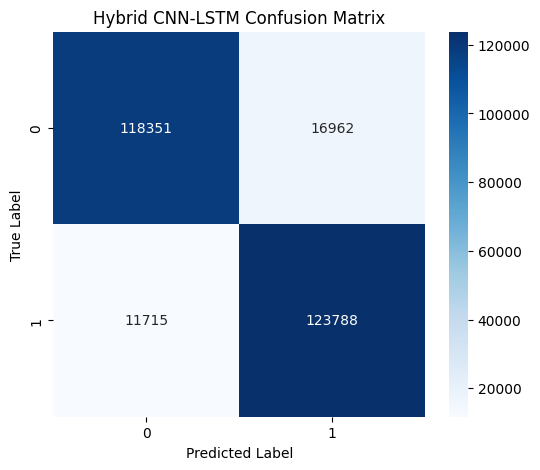

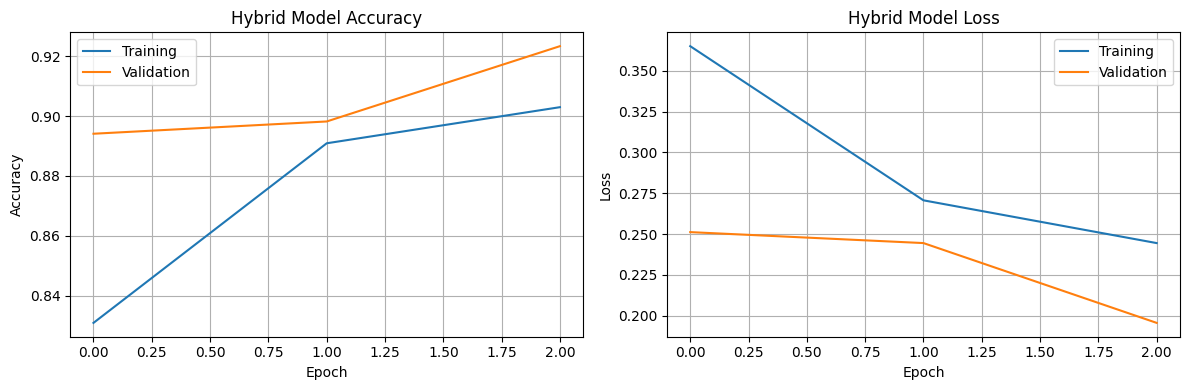

In [ ]:
# 3. Evaluasi Model Hybrid CNN-LSTM
print("=== Hybrid CNN-LSTM Model Evaluation ===")
# Metrics
hybrid_loss, hybrid_acc = hybrid_model.evaluate(X_test_reshaped, y_test, verbose=0)
hybrid_pred = hybrid_model.predict(X_test_reshaped)
hybrid_pred_classes = (hybrid_pred > 0.5).astype(int)

# ROC dan AUC
hybrid_fpr, hybrid_tpr, _ = roc_curve(y_test, hybrid_pred)
hybrid_auc = auc(hybrid_fpr, hybrid_tpr)

# Precision-Recall
hybrid_precision, hybrid_recall, _ = precision_recall_curve(y_test, hybrid_pred)
hybrid_pr_auc = auc(hybrid_recall, hybrid_precision)

print(f"Hybrid Accuracy: {hybrid_acc:.4f}")
print(f"Hybrid ROC AUC: {hybrid_auc:.4f}")
print(f"Hybrid PR AUC: {hybrid_pr_auc:.4f}")
print("\nHybrid Classification Report:")
print(classification_report(y_test, hybrid_pred_classes))

# Plot Hybrid Confusion Matrix
plt.figure(figsize=(6, 5))
cm_hybrid = confusion_matrix(y_test, hybrid_pred_classes)
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues')
plt.title('Hybrid CNN-LSTM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print()

# Plot Hybrid Learning Curves
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(hybrid_history.history['accuracy'], label='Training')
plt.plot(hybrid_history.history['val_accuracy'], label='Validation')
plt.title('Hybrid Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(hybrid_history.history['loss'], label='Training')
plt.plot(hybrid_history.history['val_loss'], label='Validation')
plt.title('Hybrid Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Overall Metrics**

- **Accuracy**: `0.8941`  
  - This means the Hybrid CNN-LSTM model correctly predicted 89.41% of the test samples (both BENIGN and ATTACK labels). While still good, this accuracy is lower than the CNN and LSTM models individually, indicating potential room for improvement in hybrid architecture.

- **ROC AUC (Receiver Operating Characteristic Area Under the Curve)**: `0.9635`  
  - This measures the model's ability to distinguish between classes. A perfect model has an AUC of 1.0, while a random guess has an AUC of 0.5.  
  - A value of `0.9635` indicates good class separation, but it's slightly lower than the standalone LSTM model.  

- **PR AUC (Precision-Recall Area Under the Curve)**: `0.9635`  
  - This reflects the model's ability to balance precision and recall for the positive class. While good, it’s slightly lower than the individual PR AUCs of the CNN (`0.9786`) and LSTM (`0.9901`) models, suggesting a trade-off in the hybrid approach.  

The evaluation of the Hybrid CNN-LSTM model demonstrates a strong performance in classifying BENIGN and ATTACK labels, achieving an overall accuracy of **89.41%**. This indicates that the model correctly predicts 89.41% of the test samples. However, this accuracy is slightly lower than the standalone CNN and LSTM models, suggesting that while the hybrid approach attempts to combine the strengths of both architectures, it may not fully capitalize on their individual advantages. The **ROC AUC** and **PR AUC**, both at **0.9635**, reflect the model's solid ability to distinguish between the two classes and balance precision and recall, respectively. However, these values are marginally lower than those of the standalone models, indicating room for optimization in the hybrid integration.

The classification report further reveals that the model achieves a balanced performance across both classes. For BENIGN (class 0), the precision, recall, and F1-score are 0.91, 0.87, and 0.89, while for ATTACK (class 1), these metrics are 0.88, 0.91, and 0.90. This indicates that the model slightly prioritizes minimizing false negatives for the ATTACK class, which is a crucial aspect in security-related tasks. The **confusion matrix** supports this analysis, showing **118,351 true negatives**, **16,962 false positives**, **11,715 false negatives**, and **123,788 true positives**. The higher false positives suggest the model leans slightly toward predicting the ATTACK class, which may result in overestimations.

The learning curves illustrate consistent improvements in both training and validation accuracy across epochs, with validation accuracy exceeding **92%**. Similarly, the training and validation losses steadily decrease, indicating that the model generalizes well without signs of overfitting. However, the slightly higher validation accuracy compared to training accuracy may indicate potential underfitting or a need for hyperparameter tuning to improve convergence.

In summary, the Hybrid CNN-LSTM model achieves robust performance with balanced metrics and strong generalization capabilities. However, its slightly lower accuracy and AUC scores compared to standalone models highlight areas for potential improvement, such as refining the hybrid architecture or addressing class imbalances more effectively.

### **8.4 Final Comparison of All Models**

Finally, the performances of all three models are compared using a summary table and visualizations of their ROC and Precision-Recall curves.

=== Final Model Comparison ===

Model Performance Comparison:
             Model  Accuracy  ROC AUC  PR AUC
0              CNN    0.9319   0.9804  0.9786
1             LSTM    0.9565   0.9912  0.9901
2  Hybrid CNN-LSTM    0.8941   0.9635  0.9635



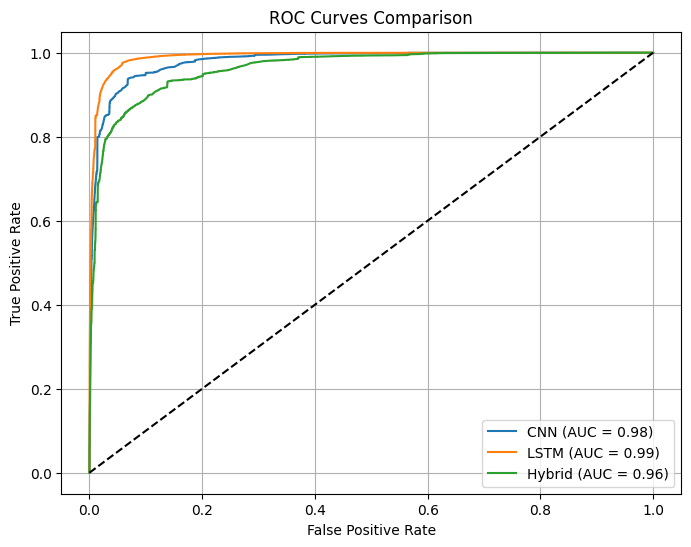

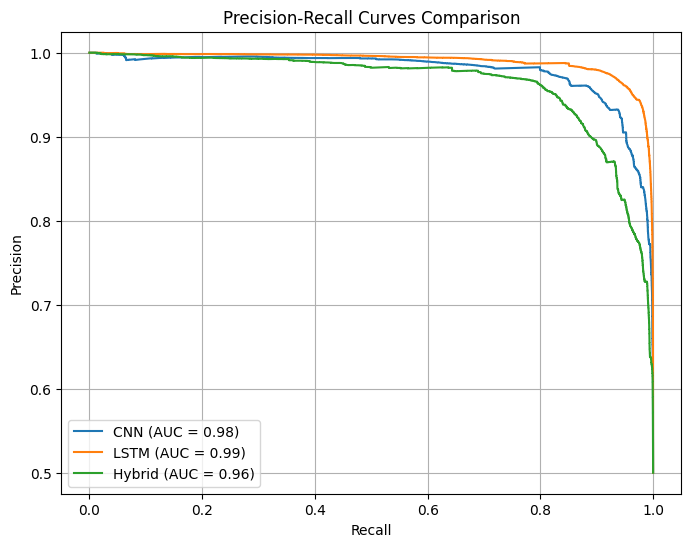

In [ ]:
# 4. Perbandingan Final Semua Model
print("=== Final Model Comparison ===")
comparison_df = pd.DataFrame({
    'Model': ['CNN', 'LSTM', 'Hybrid CNN-LSTM'],
    'Accuracy': [cnn_acc, lstm_acc, hybrid_acc],
    'ROC AUC': [cnn_auc, lstm_auc, hybrid_auc],
    'PR AUC': [cnn_pr_auc, lstm_pr_auc, hybrid_pr_auc]
})
print("\nModel Performance Comparison:")
print(comparison_df.round(4))
print()

# Plot ROC Curves Comparison
plt.figure(figsize=(8, 6))
plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {cnn_auc:.2f})')
plt.plot(lstm_fpr, lstm_tpr, label=f'LSTM (AUC = {lstm_auc:.2f})')
plt.plot(hybrid_fpr, hybrid_tpr, label=f'Hybrid (AUC = {hybrid_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()
print()

# Plot Precision-Recall Curves Comparison
plt.figure(figsize=(8, 6))
plt.plot(cnn_recall, cnn_precision, label=f'CNN (AUC = {cnn_pr_auc:.2f})')
plt.plot(lstm_recall, lstm_precision, label=f'LSTM (AUC = {lstm_pr_auc:.2f})')
plt.plot(hybrid_recall, hybrid_precision, label=f'Hybrid (AUC = {hybrid_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

### **Model Performance Comparison**

Based on the provided results and visualizations, here is a detailed analysis of the final comparison between the models:

The performance of three models—CNN, LSTM, and a Hybrid CNN-LSTM—was evaluated and compared using key metrics, including Accuracy, ROC AUC, and PR AUC. The results are summarized as follows:

1. **Accuracy**:
   The LSTM model achieved the highest accuracy of **95.65%**, followed by CNN at **93.19%**, while the Hybrid CNN-LSTM model scored the lowest at **89.41%**. This indicates that the LSTM model has the best ability to correctly classify both positive and negative samples in this dataset.

2. **ROC AUC (Receiver Operating Characteristic Area Under Curve)**:
   The ROC AUC metric evaluates the trade-off between the true positive rate and the false positive rate. LSTM achieved the highest ROC AUC of **0.9912**, closely followed by CNN with **0.9804**. The Hybrid model lagged behind with a score of **0.9635**. This suggests that LSTM is the most effective in distinguishing between classes across various threshold levels.

3. **PR AUC (Precision-Recall Area Under Curve)**:
   The PR AUC metric reflects the balance between precision and recall, especially for imbalanced datasets. LSTM again outperformed other models with a PR AUC of **0.9901**, with CNN achieving **0.9786**, and the Hybrid model slightly behind at **0.9635**. This reinforces the robustness of the LSTM model in maintaining high precision and recall across different thresholds.

4. **Visual Comparison of ROC and Precision-Recall Curves**:
   - **ROC Curves**: The ROC curve comparison highlights the superior performance of the LSTM model, as its curve is consistently closer to the top-left corner. CNN performed slightly worse but still showed strong classification capabilities. The Hybrid model's curve demonstrates comparatively weaker performance, particularly at higher false positive rates.
   - **Precision-Recall Curves**: The PR curves follow a similar trend, with LSTM leading and maintaining high precision at a wide range of recall values. CNN is close but slightly less effective, while the Hybrid model demonstrates noticeable drops in precision as recall increases.

### **Conclusion**
The analysis demonstrates that the **LSTM model** is the best performer across all metrics (Accuracy, ROC AUC, and PR AUC). It provides the most reliable predictions, both in distinguishing between classes and balancing precision and recall. The **CNN model** is a close second and could be a viable alternative depending on computational resources. The **Hybrid CNN-LSTM model**, while still reasonably effective, underperforms compared to the standalone CNN and LSTM models, suggesting that the hybrid architecture might not effectively combine the strengths of both models in this particular task.

### **Recommendation**
Based on the experiment results:
1. **Choose LSTM** if achieving the best performance is the priority and computational resources allow.
2. **Use CNN** if slightly lower performance is acceptable in exchange for faster training and inference.
3. Avoid using the hybrid CNN-LSTM model for this specific dataset, as it does not provide performance benefits over the individual models.